
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_19512/1045958014.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


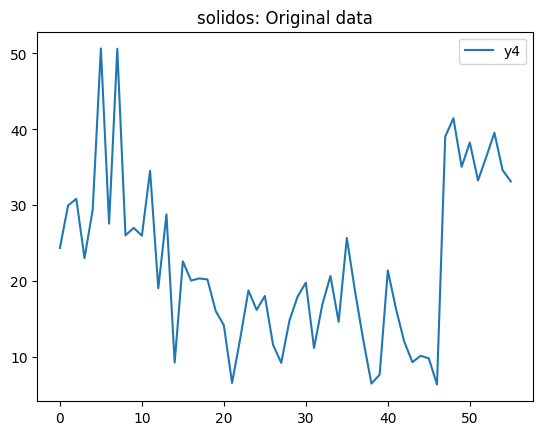

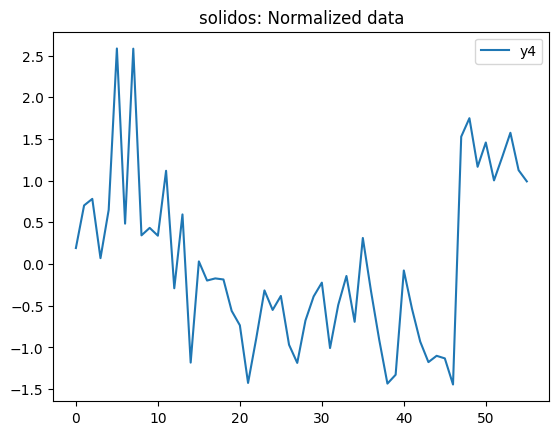

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import plotly.express as px

scaler = StandardScaler()

def getData(output, label):
    df_orig = pd.read_excel("../../../data.xlsx")
    df_orig.plot(y=[output], title=f"{label}: Original data")
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df.plot(y=[output], title=f"{label}: Normalized data")
    return (df)

def create_dataframe(output, label):
    df = getData(output, label)
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    return output, input

output, input = create_dataframe(output="y4", label="solidos")



In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-03-28 20:12:56.579357: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 20:12:59.141819: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 20:12:59.141849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 20:12:59.516366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 20:13:00.351264: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 20:13:00.352465: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error


class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
 
 
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
          self.test_prediction = self.lm_model.predict(self.test_input)

          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.test_prediction.flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()

          r2 = r2_score(self.output, pred)
          r2_test = r2_score(self.test_output, test_pred)
          r2_val = r2_score(self.val_output, val_pred)
          r2_vt = r2_score(self.vt_output, vt_pred)

          mse = mean_squared_error(self.output, pred)
          mse_test = mean_squared_error(self.test_output, test_pred)
          mse_val = mean_squared_error(self.val_output, val_pred)
          mse_vt = mean_squared_error(self.vt_output, vt_pred)

          metrics = {
                          'r2': r2,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt
                          }

          return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._train, trainer._vt, trainer._val, trainer._test), f)


  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinacao1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  1.0670878189998803
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.47606625099979283
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.683725706000132
Stopped at epoch:  10
1/1 [==============================] - 0s 30ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.5266377630000534
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.49783732400010194
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.3991775500003314
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 7 +++++++++++++

2024-03-28 20:15:35.337455: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.5299818380003671
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_0] | 23 ++++++++++++++++++
Elapsed time:  0.5852554840002995
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_0] | 24 ++++++++++++++++++
Elapsed time:  0.04230204099985713
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_0] | 25 ++++++++++++++++++
Elapsed time:  0.059199308999723144
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_1] | 1 ++++++++++++++++++
Elapsed time:  0.06559684600006221
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Elapsed time:  0.046428836999893974
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Elapsed time:  0.030083310999998503
Stopped at epoch:  0
1/1 [==============================] - 0s 48ms

2024-03-28 20:17:23.905398: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3745426700002099
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_0] | 22 ++++++++++++++++++
Elapsed time:  0.30317432199990435
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_0] | 23 ++++++++++++++++++
Elapsed time:  0.3760441989998071
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_0] | 24 ++++++++++++++++++
Elapsed time:  0.32845144200018694
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [3_0] | 25 ++++++++++++++++++
Elapsed time:  0.3197920659999909
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_1] | 1 ++++++++++++++++++
Elapsed time:  0.5450566750000689
Stopped at epoch:  10
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Elapsed time:  0.45099652800035983
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/st

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.802469,0.483862,0.779035,0.693971,0.197531,0.314542,0.359457,0.335679
model_3_8_4,0.803176,0.221984,0.658864,0.533076,0.196824,0.474134,0.554945,0.512163
model_3_8_3,0.806463,0.289760,0.685906,0.571883,0.193537,0.432830,0.510955,0.469595
model_3_8_1,0.806971,0.422797,0.746248,0.653127,0.193029,0.351756,0.412794,0.380480
model_3_8_2,0.807973,0.357286,0.715079,0.612105,0.192027,0.391679,0.463498,0.425476


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.4023069059999216
Stopped at epoch:  9
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.36460523000005196
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.34012382499986415
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.32625449499983006
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.3904107049997947
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.398778730000231
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.3839539250

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_6,0.801198,-0.028880,0.666957,0.320122,0.198802,0.865733,0.283819,0.591891
model_3_9_5,0.803878,-0.010418,0.705791,0.347458,0.196122,0.850198,0.250724,0.568093
model_3_9_4,0.806228,0.012554,0.745953,0.377713,0.193772,0.830869,0.216498,0.541753
model_3_9_3,0.808299,0.044211,0.785473,0.412116,0.191701,0.804231,0.182819,0.511802
model_3_9_0,0.809263,0.239138,0.847171,0.540278,0.190737,0.640214,0.130241,0.400227
model_3_9_2,0.810129,0.091095,0.820034,0.452026,0.189871,0.764782,0.153367,0.477058
model_3_9_1,0.811108,0.157603,0.842865,0.496575,0.188892,0.708820,0.133910,0.438274


DataFrame salvo em ../results/metrics_3_9
Testando combinacao4: Hidden Size=[10], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.62538365599994
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.4565158469999915
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.2927375540002686
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.3506921279999915
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.35267820399985794
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.3298155460001908
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_0,0.801361,-0.059848,-0.499058,-0.161480,0.198639,0.753225,0.450095,0.610576
model_4_5_1,0.805181,-0.058467,-0.473108,-0.153516,0.194819,0.752244,0.442304,0.606389
model_4_5_2,0.808344,-0.057276,-0.450488,-0.146584,0.191656,0.751397,0.435512,0.602745
model_4_5_3,0.810962,-0.056300,-0.430800,-0.140594,0.189038,0.750704,0.429601,0.599596
model_4_5_4,0.813127,-0.055536,-0.413644,-0.135437,0.186873,0.750161,0.424450,0.596885
model_4_5_5,0.814920,-0.054963,-0.398663,-0.131000,0.185080,0.749754,0.419952,0.594553
model_4_5_6,0.816406,-0.054559,-0.385552,-0.127185,0.183594,0.749467,0.416015,0.592547
model_4_5_7,0.817639,-0.054296,-0.374038,-0.123904,0.182361,0.749280,0.412558,0.590822
model_4_5_8,0.818663,-0.054152,-0.363901,-0.121076,0.181337,0.749177,0.409514,0.589336
model_4_5_9,0.819517,-0.054099,-0.354954,-0.118633,0.180483,0.749140,0.406828,0.588052


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.5507158340001297
Stopped at epoch:  10
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.3230334310001126
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.308738066999922
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.35796897499994884
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.3146951429998808
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.3475422449996586
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.39044231599

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_0,0.928836,0.835999,0.994261,0.953369,0.071164,0.091488,0.009238,0.052782
model_4_6_1,0.938375,0.828161,0.992767,0.950324,0.061625,0.095860,0.011645,0.056229
model_4_6_2,0.945728,0.818750,0.991330,0.946907,0.054272,0.101110,0.013957,0.060097
model_4_6_3,0.951347,0.808213,0.989958,0.943239,0.048653,0.106988,0.016166,0.064248
model_4_6_4,0.955591,0.796937,0.988650,0.939422,0.044409,0.113278,0.018272,0.068569
model_4_6_5,0.958749,0.785254,0.987404,0.935539,0.041251,0.119796,0.020278,0.072964
model_4_6_6,0.961050,0.773437,0.986220,0.931664,0.038950,0.126388,0.022183,0.077351
model_4_6_24,0.961384,0.637754,0.974827,0.888638,0.038616,0.202079,0.040524,0.126053
model_4_6_23,0.961676,0.641241,0.975091,0.889725,0.038324,0.200133,0.040098,0.124823
model_4_6_22,0.961985,0.645076,0.975383,0.890920,0.038015,0.197994,0.039629,0.123469


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.3360789839998688
Stopped at epoch:  7
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.3696838519999801
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.39061346599964963
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.3374017989999629
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.356903321000118
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.3270949429997927
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.392827300000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_24,0.941284,0.459891,0.784218,0.682311,0.058716,0.278972,0.096462,0.193085
model_4_7_23,0.941785,0.464504,0.786440,0.685155,0.058215,0.276590,0.095469,0.191356
model_4_7_22,0.942337,0.469612,0.788902,0.688306,0.057663,0.273951,0.094368,0.189441
model_4_7_21,0.942945,0.475271,0.791627,0.691795,0.057055,0.271028,0.093150,0.187321
model_4_7_20,0.943613,0.481533,0.794645,0.695657,0.056387,0.267794,0.091801,0.184974
model_4_7_19,0.944346,0.488461,0.797985,0.699930,0.055654,0.264216,0.090308,0.182377
model_4_7_18,0.945150,0.496119,0.801679,0.704654,0.054850,0.260260,0.088656,0.179505
model_4_7_17,0.946030,0.504578,0.805765,0.709874,0.053970,0.255891,0.086829,0.176332
model_4_7_16,0.946990,0.513915,0.810281,0.715638,0.053010,0.251068,0.084811,0.172829
model_4_7_15,0.948034,0.524206,0.815269,0.721995,0.051966,0.245753,0.082581,0.168966


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.7156793310000467
Stopped at epoch:  13
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.4225254349998977
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.40636690500014083
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.3368110000001252
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.33390799600010723
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.36253403799992157
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.32383641

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_24,0.901539,-0.085175,0.660828,0.328824,0.098461,0.462188,0.168972,0.324204
model_4_8_23,0.902140,-0.079017,0.663472,0.332982,0.097860,0.459565,0.167655,0.322196
model_4_8_22,0.902803,-0.072187,0.666397,0.337589,0.097197,0.456656,0.166198,0.319970
model_4_8_21,0.903537,-0.064614,0.669627,0.342693,0.096463,0.453431,0.164589,0.317505
model_4_8_20,0.904347,-0.056219,0.673196,0.348343,0.095653,0.449855,0.162811,0.314776
model_4_8_19,0.905241,-0.046918,0.677133,0.354596,0.094759,0.445894,0.160849,0.311755
model_4_8_18,0.906228,-0.036611,0.681475,0.361515,0.093772,0.441504,0.158686,0.308413
model_4_8_17,0.907315,-0.025197,0.686256,0.369163,0.092685,0.436643,0.156304,0.304719
model_4_8_16,0.908512,-0.012563,0.691518,0.377614,0.091488,0.431262,0.153683,0.300637
model_4_8_15,0.909828,0.001418,0.697297,0.386945,0.090172,0.425307,0.150804,0.296129


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.557651875999909
Stopped at epoch:  10
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.3792066769997291
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.3352421750000758
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.3452534289999676
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.31750562300021556
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.32035347300006833
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.3275872919

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_24,0.921198,0.530826,0.941656,0.782336,0.078802,0.420937,0.076761,0.258972
model_4_9_23,0.921748,0.534581,0.941935,0.783981,0.078252,0.417568,0.076393,0.257015
model_4_9_22,0.922352,0.538740,0.942244,0.785802,0.077648,0.413836,0.075986,0.254848
model_4_9_21,0.923015,0.543349,0.942588,0.787821,0.076985,0.409702,0.075535,0.252447
model_4_9_20,0.923739,0.548448,0.942968,0.790054,0.076261,0.405127,0.075035,0.249789
model_4_9_19,0.924531,0.554089,0.943389,0.792526,0.075469,0.400065,0.074481,0.246849
model_4_9_18,0.925393,0.560328,0.943855,0.795259,0.074607,0.394468,0.073867,0.243597
model_4_9_17,0.926330,0.567222,0.944372,0.798280,0.073670,0.388282,0.073187,0.240002
model_4_9_16,0.927345,0.574834,0.944945,0.801617,0.072655,0.381453,0.072434,0.236032
model_4_9_15,0.928440,0.583233,0.945578,0.805300,0.071560,0.373918,0.071600,0.231651


DataFrame salvo em ../results/metrics_4_9
Testando combinacao5: Hidden Size=[15], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.7090978229998655
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.41175645499970415
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.4427184959999977
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.4597004869997363
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.4158030400003554
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.28200811900023837
Stopped at epoch:  6
1/1 [==============================] - 0s 17

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_2_24,0.815021,0.569360,0.195195,0.466889,0.184979,0.638090,0.571416,0.606714
model_5_2_23,0.817314,0.575217,0.205899,0.474069,0.182686,0.629411,0.563815,0.598543
model_5_2_22,0.819811,0.581645,0.217707,0.481966,0.180189,0.619887,0.555432,0.589555
model_5_2_21,0.822522,0.588688,0.230720,0.490642,0.177478,0.609450,0.546193,0.579682
model_5_2_0,0.825332,0.900867,0.816522,0.877803,0.174668,0.146888,0.130270,0.139068
model_5_2_20,0.825458,0.596398,0.245044,0.500161,0.174542,0.598028,0.536022,0.568849
model_5_2_19,0.828626,0.604823,0.260791,0.510591,0.171374,0.585544,0.524842,0.556979
model_5_2_18,0.832029,0.614015,0.278077,0.522002,0.167971,0.571924,0.512569,0.543992
model_5_2_17,0.835670,0.624029,0.297017,0.534465,0.164330,0.557085,0.499121,0.529808
model_5_2_16,0.839541,0.634918,0.317728,0.548051,0.160459,0.540952,0.484417,0.514347


DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Elapsed time:  0.3914434610001081
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Elapsed time:  0.36786592099997506
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Elapsed time:  0.26395063800009666
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Elapsed time:  0.32677947599995605
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Elapsed time:  0.24932847399986713
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Elapsed time:  0.36023635599985937
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Elapsed time:  0.3268353

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_0,0.871889,0.978034,0.906521,0.957703,0.128111,0.029674,0.058670,0.043319
model_5_3_1,0.890962,0.970742,0.894678,0.949195,0.109038,0.039525,0.066103,0.052032
model_5_3_2,0.905138,0.962684,0.875453,0.938024,0.094862,0.050411,0.078169,0.063474
model_5_3_24,0.913032,0.863923,0.367766,0.722647,0.086968,0.183829,0.396806,0.284054
model_5_3_23,0.913957,0.865364,0.376516,0.726177,0.086043,0.181882,0.391314,0.280438
model_5_3_22,0.914958,0.866958,0.386198,0.730082,0.085042,0.179729,0.385238,0.276439
model_5_3_3,0.915295,0.954276,0.849318,0.924615,0.084705,0.061770,0.094572,0.077206
model_5_3_21,0.916036,0.868717,0.396904,0.734398,0.083964,0.177353,0.378518,0.272019
model_5_3_20,0.917194,0.870660,0.408738,0.739167,0.082806,0.174729,0.371091,0.267134
model_5_3_19,0.918430,0.872802,0.421806,0.744432,0.081570,0.171834,0.362890,0.261742


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.3345805610001662
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.3355065249998006
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.4597270379999827
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.33520645799990234
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.35954307299971333
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.3566411629999493
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.3603185580

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_24,0.914737,0.904793,-0.084837,0.595189,0.085263,0.085475,0.498869,0.280013
model_5_4_23,0.915451,0.906387,-0.076538,0.598880,0.084549,0.084044,0.495052,0.277459
model_5_4_22,0.916231,0.908137,-0.067360,0.602954,0.083769,0.082472,0.490832,0.274641
model_5_4_21,0.917082,0.910057,-0.057215,0.607447,0.082918,0.080749,0.486167,0.271534
model_5_4_20,0.918006,0.912159,-0.046015,0.612395,0.081994,0.078862,0.481016,0.268111
model_5_4_19,0.919008,0.914456,-0.033658,0.617839,0.080992,0.076800,0.475334,0.264345
model_5_4_18,0.920090,0.916962,-0.020033,0.623824,0.079910,0.074549,0.469068,0.260205
model_5_4_17,0.921254,0.919691,-0.005036,0.630391,0.078746,0.072099,0.462172,0.255663
model_5_4_0,0.922402,0.990406,0.459240,0.824231,0.077598,0.008613,0.248672,0.121582
model_5_4_16,0.922499,0.922655,0.011455,0.637587,0.077501,0.069438,0.454589,0.250685


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.4016723320000892
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.4190220219998082
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.36465519400007906
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.3513083779998851
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.35136274899969067
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.31197706600005404
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.324563072

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.927868,0.884941,0.973665,0.937708,0.072132,0.134451,0.021579,0.081335
model_5_5_1,0.937858,0.895255,0.965315,0.940129,0.062142,0.122399,0.028421,0.078174
model_5_5_2,0.945328,0.902681,0.954766,0.940532,0.054672,0.113722,0.037065,0.077648
model_5_5_24,0.948726,0.888769,0.742999,0.871401,0.051274,0.129978,0.210588,0.167912
model_5_5_23,0.949328,0.889831,0.747038,0.873097,0.050672,0.128737,0.207279,0.165698
model_5_5_22,0.949978,0.890982,0.751484,0.874955,0.050022,0.127392,0.203636,0.163272
model_5_5_21,0.950676,0.892225,0.756368,0.876987,0.049324,0.125940,0.199634,0.160619
model_5_5_3,0.950790,0.907797,0.942658,0.939380,0.049210,0.107743,0.046986,0.079152
model_5_5_20,0.951422,0.893562,0.761730,0.879204,0.048578,0.124377,0.195240,0.157725
model_5_5_19,0.952215,0.894994,0.767606,0.881617,0.047785,0.122704,0.190426,0.154573


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.37640527099983956
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.3118131189999076
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.29650719199980813
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.3770934969998052
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.3204434220001531
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.33521078400008264
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.394722365

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_0,0.955791,0.961398,0.855245,0.897727,0.044209,0.009975,0.085652,0.045587
model_5_6_1,0.961211,0.959356,0.852141,0.895161,0.038789,0.010502,0.087489,0.046731
model_5_6_2,0.965332,0.956095,0.847243,0.891101,0.034668,0.011345,0.090386,0.048541
model_5_6_3,0.968431,0.951970,0.841184,0.886050,0.031569,0.012411,0.093972,0.050792
model_5_6_4,0.970731,0.947257,0.834447,0.880395,0.029269,0.013629,0.097958,0.053313
model_5_6_5,0.972406,0.942180,0.827389,0.874428,0.027594,0.014940,0.102134,0.055973
model_5_6_24,0.973017,0.873396,0.745285,0.802029,0.026983,0.032714,0.150716,0.088244
model_5_6_23,0.973190,0.875050,0.747058,0.803644,0.026810,0.032287,0.149666,0.087524
model_5_6_22,0.973375,0.876868,0.749016,0.805425,0.026625,0.031817,0.148508,0.086730
model_5_6_21,0.973571,0.878863,0.751175,0.807386,0.026429,0.031301,0.147230,0.085856


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.3357422450003469
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.26172749599982126
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.34859592200018596
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.29668170600007215
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.34273943000016516
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.3353397659998336
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.35337201

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_24,0.957357,0.744759,0.903483,0.840495,0.042643,0.178479,0.096857,0.140069
model_5_7_23,0.958072,0.749406,0.905024,0.843283,0.041928,0.175230,0.095311,0.137621
model_5_7_22,0.958852,0.754502,0.906719,0.846342,0.041148,0.171667,0.093610,0.134934
model_5_7_21,0.959702,0.760080,0.908580,0.849695,0.040298,0.167766,0.091742,0.131990
model_5_7_20,0.960626,0.766176,0.910622,0.853364,0.039374,0.163503,0.089692,0.128769
model_5_7_19,0.961627,0.772825,0.912859,0.857369,0.038373,0.158853,0.087448,0.125251
model_5_7_18,0.962709,0.780061,0.915303,0.861734,0.037291,0.153794,0.084995,0.121418
model_5_7_17,0.963873,0.787915,0.917969,0.866479,0.036127,0.148302,0.082320,0.117251
model_5_7_16,0.965119,0.796417,0.920870,0.871623,0.034881,0.142357,0.079408,0.112734
model_5_7_15,0.966447,0.805589,0.924019,0.877183,0.033553,0.135943,0.076249,0.107852


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  1.1519489039997097
Stopped at epoch:  22
1/1 [==============================] - 0s 28ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.3842213540001467
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.39895247200001904
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.3436299919999328
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.3203537850004068
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.4430259650002881
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.3585569130

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.979476,0.758872,0.982750,0.946384,0.020524,0.100120,0.031005,0.067595
model_5_8_23,0.979515,0.759564,0.982729,0.946490,0.020485,0.099833,0.031044,0.067462
model_5_8_22,0.979559,0.760331,0.982704,0.946607,0.020441,0.099514,0.031088,0.067313
model_5_8_21,0.979607,0.761180,0.982677,0.946737,0.020393,0.099161,0.031137,0.067150
model_5_8_20,0.979661,0.762122,0.982647,0.946881,0.020339,0.098770,0.031191,0.066968
model_5_8_19,0.979719,0.763166,0.982613,0.947040,0.020281,0.098337,0.031252,0.066767
model_5_8_18,0.979784,0.764321,0.982575,0.947216,0.020216,0.097857,0.031320,0.066545
model_5_8_17,0.979855,0.765600,0.982533,0.947411,0.020145,0.097326,0.031395,0.066300
model_5_8_16,0.979933,0.767017,0.982486,0.947626,0.020067,0.096738,0.031480,0.066028
model_5_8_15,0.980019,0.768583,0.982433,0.947864,0.019981,0.096088,0.031575,0.065729


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.7027628719997665
Stopped at epoch:  12
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.33766639300029055
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.31476403999977265
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.3537070610000228
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.36310459199967227
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.3016340379999747
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.33722808

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.992575,0.983073,0.987165,0.987825,0.007425,0.014458,0.016742,0.015533
model_5_9_1,0.993251,0.983801,0.987488,0.988239,0.006750,0.013836,0.016320,0.015005
model_5_9_2,0.993785,0.984366,0.987698,0.988540,0.006215,0.013354,0.016046,0.014621
model_5_9_3,0.994206,0.984801,0.987823,0.988754,0.005794,0.012982,0.015884,0.014348
model_5_9_4,0.994536,0.985133,0.987883,0.988901,0.005464,0.012698,0.015805,0.014160
model_5_9_5,0.994795,0.985385,0.987896,0.988996,0.005205,0.012483,0.015789,0.014039
model_5_9_6,0.994996,0.985574,0.987874,0.989052,0.005004,0.012322,0.015818,0.013967
model_5_9_7,0.995151,0.985712,0.987827,0.989079,0.004849,0.012204,0.015879,0.013933
model_5_9_8,0.995271,0.985813,0.987763,0.989084,0.004729,0.012118,0.015962,0.013927
model_5_9_9,0.995362,0.985882,0.987688,0.989072,0.004638,0.012059,0.016060,0.013942


DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.7701463590001367
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.42632301599996936
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.3195842189998075
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.31017113699999754
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.32020669899975474
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.41369527999995626
Stopped at epoch:  6
1/1 [==============================] - 0s 2

2024-03-28 20:26:51.884816: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3615267830000448
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_3] | 11 ++++++++++++++++++
Elapsed time:  0.38893707899978835
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step


2024-03-28 20:26:52.789060: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_3] | 12 ++++++++++++++++++
Elapsed time:  0.34101749899991773
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_3] | 13 ++++++++++++++++++
Elapsed time:  0.39011406200006604
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_3] | 14 ++++++++++++++++++
Elapsed time:  0.3715118799996162
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_3] | 15 ++++++++++++++++++
Elapsed time:  0.36108083199997054
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_3] | 16 ++++++++++++++++++
Elapsed time:  0.32483626100020047
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_3] | 17 ++++++++++++++++++
Elapsed time:  0.2878387490000023
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_3] | 18 ++++++++++++++++++
Elapsed 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.800784,0.451868,0.558917,0.577355,0.199216,0.306378,0.676405,0.480508
model_6_5_1,0.806561,0.414576,0.554280,0.564706,0.193439,0.327222,0.683515,0.494889
model_6_5_18,0.808967,0.110020,0.498426,0.449982,0.191033,0.497453,0.769168,0.625319
model_6_5_17,0.809604,0.116788,0.499845,0.452645,0.190396,0.493670,0.766991,0.622292
model_6_5_16,0.810279,0.124328,0.501424,0.455610,0.189721,0.489456,0.764570,0.618921
model_6_5_2,0.810573,0.379867,0.549342,0.552537,0.189427,0.346623,0.691088,0.508724
model_6_5_15,0.810988,0.132726,0.503181,0.458910,0.189012,0.484762,0.761877,0.615169
model_6_5_14,0.811726,0.142083,0.505132,0.462585,0.188274,0.479532,0.758884,0.610991
model_6_5_13,0.812482,0.152509,0.507300,0.466674,0.187518,0.473704,0.755560,0.606342
model_6_5_3,0.813241,0.347797,0.544320,0.541002,0.186759,0.364548,0.698789,0.521838


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.44983617500020046
Stopped at epoch:  8
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.387803516999611
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.3214113779999934
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.3407405429998107
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.41594156699966334
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.3231203430000278
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.36502855099

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_0,0.868782,0.807388,0.941114,0.871286,0.131218,0.244477,0.072926,0.163747
model_6_6_1,0.880076,0.795000,0.932337,0.860722,0.119924,0.260200,0.083796,0.177186
model_6_6_2,0.888517,0.782783,0.923606,0.850269,0.111483,0.275707,0.094608,0.190484
model_6_6_24,0.894261,0.627949,0.834302,0.727575,0.105739,0.472234,0.205204,0.346573
model_6_6_3,0.894717,0.770898,0.915110,0.840099,0.105283,0.290793,0.105130,0.203422
model_6_6_23,0.894901,0.630754,0.835385,0.729553,0.105099,0.468672,0.203864,0.344056
model_6_6_22,0.895591,0.633838,0.836595,0.731736,0.104409,0.464758,0.202365,0.341279
model_6_6_21,0.896332,0.637224,0.837948,0.734144,0.103668,0.460461,0.200689,0.338215
model_6_6_20,0.897124,0.640935,0.839462,0.736798,0.102876,0.455751,0.198814,0.334839
model_6_6_19,0.897964,0.644994,0.841156,0.739718,0.102036,0.450599,0.196716,0.331125


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.3912791540001308
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.36866112300003806
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.3301477740001246
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.35129923199974655
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.47091905299976133
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.36522949499976676
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.34449956

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_24,0.807318,-1.377895,0.314654,-0.009506,0.192682,0.707743,0.550800,0.633887
model_6_7_23,0.809792,-1.335870,0.319208,0.003782,0.190208,0.695235,0.547141,0.625544
model_6_7_22,0.812505,-1.289660,0.324222,0.018399,0.187495,0.681481,0.543110,0.616365
model_6_7_21,0.815476,-1.238909,0.329741,0.034458,0.184524,0.666376,0.538675,0.606281
model_6_7_20,0.818723,-1.183256,0.335805,0.052076,0.181277,0.649812,0.533802,0.595219
model_6_7_19,0.822265,-1.122329,0.342456,0.071371,0.177735,0.631678,0.528456,0.583103
model_6_7_18,0.826117,-1.055749,0.349739,0.092465,0.173883,0.611861,0.522603,0.569858
model_6_7_17,0.830294,-0.983158,0.357696,0.115474,0.169706,0.590256,0.516208,0.555410
model_6_7_16,0.834809,-0.904206,0.366369,0.140510,0.165191,0.566757,0.509238,0.539689
model_6_7_15,0.839670,-0.818581,0.375791,0.167672,0.160330,0.541272,0.501666,0.522634


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.30112896899981934
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.37036420800041014
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.33574096400025155
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.4006429140004002
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.3190034169997489
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.3650867400001516
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.350620123

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_24,0.834008,0.350596,-0.581342,0.396296,0.165992,0.591745,0.489414,0.543590
model_6_8_23,0.835549,0.357779,-0.565109,0.402770,0.164451,0.585200,0.484391,0.537760
model_6_8_22,0.837259,0.365821,-0.546714,0.410054,0.162741,0.577872,0.478697,0.531202
model_6_8_21,0.839154,0.374836,-0.525844,0.418260,0.160846,0.569658,0.472238,0.523813
model_6_8_20,0.841255,0.384949,-0.502129,0.427514,0.158745,0.560442,0.464899,0.515481
model_6_8_0,0.842385,0.969744,0.885144,0.965212,0.157615,0.027569,0.035547,0.031324
model_6_8_19,0.843582,0.396304,-0.475159,0.437959,0.156418,0.550096,0.456552,0.506075
model_6_8_18,0.846155,0.409060,-0.444460,0.449759,0.153845,0.538472,0.447051,0.495450
model_6_8_17,0.848996,0.423401,-0.409499,0.463097,0.151004,0.525405,0.436230,0.483440
model_6_8_16,0.852125,0.439523,-0.369700,0.478172,0.147875,0.510714,0.423913,0.469866


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.35755971400021735
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.33183724499986056
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.41332654400002866
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.31117429699997956
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.4217441890000373
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.2867984690001322
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.27964854

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_19,0.804100,0.267408,0.365194,0.329968,0.195900,0.556376,0.730775,0.638445
model_6_9_18,0.808538,0.284431,0.382525,0.347005,0.191462,0.543447,0.710823,0.622212
model_6_9_17,0.813324,0.303016,0.401506,0.365638,0.186676,0.529333,0.688973,0.604457
model_6_9_16,0.818461,0.323262,0.422257,0.385979,0.181539,0.513957,0.665084,0.585075
model_6_9_15,0.823949,0.345264,0.444900,0.408136,0.176051,0.497247,0.639018,0.563963
model_6_9_14,0.829776,0.369106,0.469554,0.432212,0.170224,0.479140,0.610638,0.541021
model_6_9_13,0.835918,0.394857,0.496329,0.458301,0.164082,0.459583,0.579815,0.516163
model_6_9_12,0.842333,0.422565,0.525324,0.486478,0.157667,0.438540,0.546436,0.489314
model_6_9_11,0.848959,0.452243,0.556614,0.516790,0.151041,0.416000,0.510416,0.460431
model_6_9_10,0.855703,0.483857,0.590243,0.549249,0.144297,0.391991,0.471703,0.429502


DataFrame salvo em ../results/metrics_6_9
Testando combinacao7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  1.145770975999767
Stopped at epoch:  15
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.41677940800036595
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.320631252000112
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.25682685699985086
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.3603829290000249
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.267935327000032
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_11,0.802090,0.734260,0.250402,0.475702,0.197910,0.278599,1.018613,0.626841
model_7_3_10,0.805347,0.739898,0.271476,0.489591,0.194653,0.272688,0.989976,0.610235
model_7_3_0,0.807468,0.791741,0.580961,0.679191,0.192532,0.218336,0.569423,0.383553
model_7_3_9,0.808625,0.745705,0.294658,0.504686,0.191375,0.266600,0.958474,0.592188
model_7_3_8,0.811832,0.751608,0.320026,0.520995,0.188168,0.260411,0.924002,0.572689
model_7_3_1,0.814523,0.787951,0.547187,0.659367,0.185477,0.222310,0.615317,0.407255
model_7_3_7,0.814837,0.757523,0.347605,0.538491,0.185163,0.254210,0.886526,0.551771
model_7_3_6,0.817469,0.763348,0.377334,0.557096,0.182531,0.248104,0.846128,0.529527
model_7_3_2,0.818648,0.783820,0.512233,0.638753,0.181352,0.226641,0.662816,0.431900
model_7_3_5,0.819498,0.768979,0.409046,0.576672,0.180502,0.242200,0.803035,0.506122


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.39979896000022563
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.38850004099958824
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.36723313199991026
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.3339190849997067
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.33952212300027895
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.36034959700009495
Stopped at epoch:  6
1/1 [==============================] - 0s 55ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.4240512

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_17,0.801281,0.463702,-0.120997,0.337976,0.198719,0.775139,0.506721,0.648825
model_7_5_16,0.803367,0.468580,-0.099884,0.346367,0.196633,0.768088,0.497178,0.640601
model_7_5_15,0.805586,0.473913,-0.076860,0.355528,0.194414,0.760380,0.486770,0.631622
model_7_5_14,0.807929,0.479727,-0.051813,0.365504,0.192071,0.751976,0.475448,0.621845
model_7_5_0,0.810063,0.585230,0.519232,0.571819,0.189937,0.599488,0.217320,0.419644
model_7_5_13,0.810379,0.486043,-0.024647,0.376331,0.189621,0.742848,0.463169,0.611234
model_7_5_12,0.812912,0.492875,0.004724,0.388040,0.187088,0.732973,0.449892,0.599759
model_7_5_11,0.815490,0.500228,0.036367,0.400649,0.184510,0.722346,0.435588,0.587401
model_7_5_10,0.818063,0.508092,0.070329,0.414160,0.181937,0.710979,0.420237,0.574159
model_7_5_1,0.818230,0.582824,0.469928,0.559239,0.181770,0.602966,0.239607,0.431973


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.30994153099982213
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.32722013600005084
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.39342293299978337
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.3877416389996142
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.3673017359997175
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.35053607899999406
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.32421005

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.830422,0.897635,0.994354,0.958060,0.169578,0.050517,0.004823,0.029014
model_7_6_1,0.856932,0.861607,0.986612,0.939954,0.143068,0.068297,0.011436,0.041539
model_7_6_2,0.876808,0.820842,0.973702,0.917058,0.123192,0.088415,0.022463,0.057379
model_7_6_24,0.886246,0.275673,0.546913,0.463176,0.113754,0.357457,0.387020,0.371369
model_7_6_23,0.887657,0.283406,0.555405,0.471031,0.112343,0.353641,0.379766,0.365935
model_7_6_22,0.889185,0.291984,0.564767,0.479711,0.110815,0.349407,0.371769,0.359931
model_7_6_21,0.890833,0.301502,0.575076,0.489296,0.109167,0.344710,0.362963,0.353300
model_7_6_3,0.891279,0.777447,0.956028,0.890399,0.108721,0.109830,0.037560,0.075821
model_7_6_20,0.892604,0.312057,0.586415,0.499871,0.107396,0.339501,0.353278,0.345984
model_7_6_19,0.894497,0.323764,0.598870,0.511528,0.105503,0.333724,0.342639,0.337919


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.42647509999960675
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.2857946389999597
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.4426717290002671
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.31984757800000807
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.3239631550000013
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.4164745520001816
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.3597253910

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_24,0.903640,0.712599,0.454618,0.645187,0.096360,0.206444,0.441353,0.316989
model_7_7_23,0.903969,0.714134,0.456196,0.646513,0.096031,0.205341,0.440076,0.315805
model_7_7_22,0.904327,0.715833,0.457927,0.647974,0.095673,0.204120,0.438676,0.314499
model_7_7_21,0.904716,0.717715,0.459823,0.649584,0.095284,0.202768,0.437141,0.313061
model_7_7_20,0.905138,0.719795,0.461898,0.651353,0.094862,0.201274,0.435462,0.311480
model_7_7_19,0.905594,0.722096,0.464161,0.653297,0.094406,0.199622,0.433631,0.309744
model_7_7_18,0.906084,0.724638,0.466627,0.655430,0.093916,0.197796,0.431635,0.307838
model_7_7_17,0.906609,0.727445,0.469304,0.657767,0.093391,0.195779,0.429469,0.305751
model_7_7_16,0.907168,0.730544,0.472205,0.660322,0.092832,0.193553,0.427121,0.303467
model_7_7_15,0.907759,0.733962,0.475338,0.663113,0.092241,0.191098,0.424586,0.300975


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.3769215060001443
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.34654857600025935
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.27705731599962746
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.2962511840000843
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.36698736200014537
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.3038255470000877
Stopped at epoch:  6
1/1 [==============================] - 0s 53ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.302399757

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.910803,0.211461,0.997513,0.769794,0.089197,0.314549,0.001722,0.167336
model_7_8_1,0.916142,0.184248,0.995301,0.760896,0.083858,0.325405,0.003253,0.173804
model_7_8_24,0.918342,-0.129631,0.909042,0.631051,0.081658,0.450612,0.062962,0.268188
model_7_8_23,0.918734,-0.125086,0.910634,0.633085,0.081266,0.448799,0.061859,0.266710
model_7_8_22,0.919159,-0.120070,0.912387,0.635328,0.080841,0.446798,0.060646,0.265079
model_7_8_21,0.919616,-0.114542,0.914312,0.637797,0.080384,0.444593,0.059314,0.263285
model_7_8_2,0.920037,0.158181,0.991785,0.751748,0.079963,0.335803,0.005687,0.180454
model_7_8_20,0.920108,-0.108454,0.916425,0.640512,0.079892,0.442164,0.057851,0.261311
model_7_8_19,0.920633,-0.101758,0.918740,0.643495,0.079367,0.439493,0.056249,0.259143
model_7_8_18,0.921192,-0.094398,0.921271,0.646767,0.078808,0.436557,0.054497,0.256764


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.3655395329997191
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.31657457699975566
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.32315723900001103
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.30275312799994936
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.3382875909996983
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.36395753400029207
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.31523020

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_0,0.928066,0.498559,0.988067,0.866965,0.071934,0.233362,0.014483,0.130360
model_7_9_1,0.935740,0.521968,0.986648,0.872024,0.064260,0.222468,0.016205,0.125403
model_7_9_2,0.941785,0.540460,0.984753,0.875570,0.058215,0.213862,0.018504,0.121929
model_7_9_3,0.946534,0.555061,0.982557,0.877961,0.053466,0.207067,0.021170,0.119586
model_7_9_4,0.950252,0.566581,0.980187,0.879476,0.049748,0.201705,0.024047,0.118101
model_7_9_5,0.953151,0.575657,0.977737,0.880330,0.046849,0.197482,0.027020,0.117265
model_7_9_6,0.955399,0.582795,0.975276,0.880690,0.044601,0.194160,0.030007,0.116911
model_7_9_7,0.957131,0.588395,0.972854,0.880687,0.042869,0.191554,0.032946,0.116915
model_7_9_8,0.958455,0.592777,0.970507,0.880420,0.041545,0.189514,0.035794,0.117176
model_7_9_9,0.959457,0.596193,0.968259,0.879969,0.040543,0.187925,0.038523,0.117618


DataFrame salvo em ../results/metrics_7_9
Testando combinacao8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  1.0363486960000046
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.45849416900000506
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.41383564200032197
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.34546430299997155
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.35122218600008637
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.31059679100008
Stopped at epoch:  6
1/1 [==============================] - 0s 21m

2024-03-28 20:32:46.960285: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_3] | 23 ++++++++++++++++++
Elapsed time:  0.39875486299979457
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_3] | 24 ++++++++++++++++++
Elapsed time:  0.2872045869999056
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_3] | 25 ++++++++++++++++++
Elapsed time:  0.34197727999981
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.3859115059999567
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.269776111000283
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.38250717899973097
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.815253,0.896166,0.811736,0.856877,0.184747,0.113667,0.218969,0.163221
model_8_4_1,0.832667,0.887326,0.770520,0.832604,0.167333,0.123344,0.266908,0.190903
model_8_4_2,0.845300,0.878678,0.730223,0.808869,0.154700,0.132811,0.313776,0.217971
model_8_4_20,0.845859,0.793900,0.302574,0.560539,0.154141,0.225617,0.811173,0.501173
model_8_4_19,0.847511,0.795796,0.313333,0.566666,0.152489,0.223542,0.798661,0.494186
model_8_4_18,0.849268,0.797895,0.325163,0.573411,0.150732,0.221244,0.784900,0.486494
model_8_4_17,0.851122,0.800219,0.338156,0.580828,0.148878,0.218700,0.769788,0.478036
model_8_4_16,0.853061,0.802791,0.352406,0.588974,0.146939,0.215885,0.753214,0.468746
model_8_4_3,0.854211,0.870340,0.691255,0.785929,0.145789,0.141938,0.359100,0.244132
model_8_4_15,0.855066,0.805633,0.368012,0.597908,0.144934,0.212774,0.735063,0.458557


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.3378917659997569
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.3153321719996711
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.3493645749999814
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.25780515900032697
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.29855857699976696
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.3378275320001194
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.2849475779

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_21,0.802231,0.400705,-0.186647,0.106040,0.197769,0.400118,0.925068,0.647154
model_8_5_20,0.805814,0.410893,-0.161532,0.123741,0.194186,0.393316,0.905490,0.634339
model_8_5_19,0.809719,0.422139,-0.133895,0.143238,0.190281,0.385807,0.883945,0.620225
model_8_5_18,0.813963,0.434541,-0.103519,0.164687,0.186037,0.377527,0.860264,0.604698
model_8_5_17,0.818563,0.448202,-0.070183,0.188251,0.181437,0.368406,0.834277,0.587640
model_8_5_16,0.823528,0.463228,-0.033664,0.214093,0.176472,0.358375,0.805808,0.568932
model_8_5_15,0.828862,0.479727,0.006259,0.242381,0.171138,0.347359,0.774685,0.548454
model_8_5_14,0.834563,0.497805,0.049800,0.273272,0.165437,0.335290,0.740743,0.526091
model_8_5_13,0.840612,0.517561,0.097150,0.306913,0.159388,0.322100,0.703830,0.501737
model_8_5_12,0.846978,0.539080,0.148470,0.343428,0.153022,0.307732,0.663823,0.475304


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.42038317900005495
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.3621655900001315
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.3323408340002061
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.32069875599972875
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.40696923900031834
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.31730012800016993
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.31427400

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.802691,-0.072095,0.972861,0.605542,0.197309,0.826025,0.043335,0.457700
model_8_6_1,0.809741,-0.104046,0.972362,0.593987,0.190259,0.850643,0.044132,0.471109
model_8_6_2,0.814913,-0.133749,0.971733,0.583138,0.185087,0.873528,0.045136,0.483697
model_8_6_24,0.816714,-0.402152,0.959269,0.480712,0.183286,1.080327,0.065038,0.602544
model_8_6_23,0.817118,-0.398635,0.959514,0.482107,0.182882,1.077617,0.064647,0.600925
model_8_6_22,0.817555,-0.394734,0.959783,0.483653,0.182445,1.074611,0.064217,0.599131
model_8_6_21,0.818025,-0.390407,0.960079,0.485365,0.181975,1.071278,0.063745,0.597145
model_8_6_20,0.818529,-0.385611,0.960402,0.487261,0.181471,1.067582,0.063228,0.594945
model_8_6_3,0.818629,-0.161197,0.971019,0.573027,0.181371,0.894676,0.046276,0.495429
model_8_6_19,0.819066,-0.380295,0.960756,0.489359,0.180934,1.063487,0.062664,0.592511


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.3229701310001474
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.345751817999826
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.3196101869998529
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.30989310899985867
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.36341069399986736
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.3698338670001249
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.36822831499

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_0,0.847548,0.920899,0.989652,0.953368,0.152452,0.064679,0.008307,0.038151
model_8_7_1,0.870713,0.905073,0.976924,0.939118,0.129287,0.077620,0.018523,0.049809
model_8_7_2,0.887774,0.886583,0.958260,0.920717,0.112226,0.092739,0.033504,0.064863
model_8_7_24,0.894772,0.629303,0.514899,0.579881,0.105228,0.303112,0.389381,0.343709
model_8_7_23,0.895977,0.632875,0.523140,0.585576,0.104023,0.300191,0.382767,0.339050
model_8_7_22,0.897283,0.636844,0.532228,0.591872,0.102717,0.296945,0.375472,0.333899
model_8_7_21,0.898693,0.641255,0.542242,0.598829,0.101307,0.293339,0.367434,0.328207
model_8_7_3,0.900015,0.866490,0.935057,0.899372,0.099985,0.109168,0.052129,0.082326
model_8_7_20,0.900207,0.646157,0.553262,0.606511,0.099793,0.289331,0.358588,0.321922
model_8_7_19,0.901826,0.651603,0.565376,0.614985,0.098174,0.284878,0.348865,0.314989


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.38134759600006873
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.2904498370003239
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.37586980500009304
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.35372301200004586
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.3608508509996682
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.4045328160000281
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.344055665

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.905254,0.761324,0.995155,0.856747,0.094746,0.261230,0.002457,0.139454
model_8_8_1,0.913178,0.748998,0.996407,0.849717,0.086822,0.274721,0.001822,0.146298
model_8_8_2,0.919103,0.737144,0.995476,0.842433,0.080897,0.287695,0.002294,0.153389
model_8_8_3,0.923465,0.725826,0.993029,0.835097,0.076535,0.300082,0.003535,0.160530
model_8_8_24,0.924705,0.605115,0.924081,0.746348,0.075295,0.432201,0.038492,0.246926
model_8_8_23,0.925108,0.607235,0.925570,0.747976,0.074892,0.429879,0.037737,0.245342
model_8_8_22,0.925540,0.609573,0.927208,0.749768,0.074460,0.427321,0.036907,0.243597
model_8_8_21,0.926004,0.612146,0.929006,0.751740,0.073996,0.424505,0.035995,0.241677
model_8_8_20,0.926497,0.614977,0.930978,0.753909,0.073503,0.421406,0.034995,0.239566
model_8_8_4,0.926605,0.715076,0.989567,0.827850,0.073395,0.311849,0.005290,0.167585


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.5160374170000068
Stopped at epoch:  10
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.31118177100006505
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.39569121099975746
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.33336703499981013
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.30356160399969667
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.433895542999835
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.35150162

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_0,0.942166,0.610106,0.989433,0.857578,0.057834,0.305795,0.013951,0.168456
model_8_9_24,0.943177,0.577619,0.981230,0.841865,0.056823,0.331275,0.024781,0.187042
model_8_9_23,0.943289,0.578356,0.981387,0.842206,0.056711,0.330697,0.024572,0.186638
model_8_9_22,0.943412,0.579166,0.981561,0.842582,0.056588,0.330061,0.024343,0.186194
model_8_9_1,0.943521,0.610955,0.989304,0.857808,0.056479,0.305129,0.014121,0.168184
model_8_9_21,0.943545,0.580053,0.981752,0.842993,0.056455,0.329365,0.024092,0.185707
model_8_9_20,0.943688,0.581026,0.981961,0.843444,0.056312,0.328603,0.023816,0.185174
model_8_9_19,0.943842,0.582088,0.982189,0.843937,0.056158,0.327770,0.023514,0.184590
model_8_9_18,0.944006,0.583246,0.982439,0.844475,0.055994,0.326861,0.023184,0.183954
model_8_9_17,0.944181,0.584506,0.982712,0.845061,0.055819,0.325873,0.022824,0.183262


DataFrame salvo em ../results/metrics_8_9
Testando combinacao9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.6452002819996778
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.5109321190002447
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.3785578230003921
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.31276216000014756
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.39212868799995704
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.3544944119998945
Stopped at epoch:  6
1/1 [==============================] - 0s 22

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_0,0.811166,0.865221,0.155379,0.572082,0.188834,0.084355,0.563344,0.309761
model_9_4_1,0.825444,0.828054,0.151979,0.553595,0.174556,0.107617,0.565612,0.323144
model_9_4_2,0.835919,0.789661,0.147978,0.534286,0.164081,0.131646,0.568280,0.337121
model_9_4_22,0.836670,0.229219,0.109101,0.260894,0.163330,0.482414,0.594210,0.535024
model_9_4_21,0.837764,0.241350,0.110025,0.266848,0.162236,0.474821,0.593594,0.530714
model_9_4_20,0.838944,0.254743,0.111035,0.273416,0.161056,0.466439,0.592921,0.525960
model_9_4_19,0.840209,0.269515,0.112134,0.280654,0.159791,0.457194,0.592188,0.520720
model_9_4_18,0.841558,0.285783,0.113326,0.288618,0.158442,0.447012,0.591392,0.514955
model_9_4_17,0.842985,0.303671,0.114617,0.297366,0.157015,0.435816,0.590531,0.508623
model_9_4_3,0.843425,0.750227,0.144126,0.514565,0.156575,0.156327,0.570849,0.351396


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.37060369299979357
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.2735651749999306
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.3515489669998715
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.3077685179996479
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.29648639100014407
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.2628789010004766
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.3941727179

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_24,0.831273,0.562569,0.739236,0.621704,0.168727,0.818498,0.254504,0.553089
model_9_5_23,0.834060,0.569895,0.744813,0.628420,0.165940,0.804791,0.249062,0.543272
model_9_5_22,0.837115,0.578007,0.750939,0.635841,0.162885,0.789612,0.243082,0.532422
model_9_5_21,0.840457,0.586987,0.757657,0.644035,0.159543,0.772809,0.236525,0.520440
model_9_5_20,0.844106,0.596920,0.765008,0.653075,0.155894,0.754223,0.229352,0.507225
model_9_5_19,0.848077,0.607900,0.773029,0.663034,0.151923,0.733678,0.221523,0.492664
model_9_5_18,0.852386,0.620026,0.781751,0.673989,0.147614,0.710989,0.213010,0.476646
model_9_5_17,0.857042,0.633401,0.791199,0.686020,0.142958,0.685961,0.203789,0.459056
model_9_5_16,0.862049,0.648133,0.801383,0.699200,0.137951,0.658396,0.193849,0.439786
model_9_5_0,0.865881,0.995595,0.968366,0.987078,0.134119,0.008243,0.030875,0.018893


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.3535119569996823
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.3920849880005335
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.3520174329996735
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.392189490000419
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.4807010430004084
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.3184094380003444
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.3357798839997

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.852978,0.984529,0.518894,0.798520,0.147022,0.010743,0.354171,0.172356
model_9_6_1,0.870152,0.983208,0.512143,0.795218,0.129848,0.011661,0.359140,0.175181
model_9_6_2,0.883687,0.981676,0.503684,0.791134,0.116313,0.012724,0.365367,0.178674
model_9_6_3,0.894307,0.980021,0.494084,0.786535,0.105693,0.013874,0.372435,0.182608
model_9_6_4,0.902600,0.978305,0.483814,0.781639,0.097400,0.015066,0.379995,0.186797
model_9_6_5,0.909038,0.976573,0.473249,0.776616,0.090962,0.016268,0.387772,0.191094
model_9_6_6,0.914004,0.974860,0.462678,0.771599,0.085996,0.017458,0.395555,0.195386
model_9_6_7,0.917802,0.973189,0.452307,0.766681,0.082198,0.018618,0.403189,0.199593
model_9_6_8,0.920678,0.971580,0.442288,0.761932,0.079322,0.019736,0.410565,0.203655
model_9_6_9,0.922828,0.970043,0.432719,0.757397,0.077172,0.020803,0.417609,0.207535


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.42304481199971633
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.39109937800003536
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.34180537100019137
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.37734371300030034
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.36451136600044265
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.3384910189997754
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.3610959

2024-03-28 20:36:42.774102: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.498920662999808
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_7] | 16 ++++++++++++++++++
Elapsed time:  0.3510847429997739
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [9_7] | 17 ++++++++++++++++++
Elapsed time:  0.34548289499980456
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_7] | 18 ++++++++++++++++++
Elapsed time:  0.3587093169999207
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_7] | 19 ++++++++++++++++++
Elapsed time:  0.3506144150005639
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 20 ++++++++++++++++++
Elapsed time:  0.3331991550003295
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 21 ++++++++++++++++++
Elapsed time:  0.4386167259999638
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_0,0.939093,0.995657,0.930440,0.981003,0.060907,0.003603,0.025692,0.013998
model_9_7_24,0.947358,0.815688,0.474977,0.766281,0.052642,0.152917,0.193918,0.172211
model_9_7_23,0.948204,0.818887,0.484541,0.770444,0.051796,0.150263,0.190385,0.169144
model_9_7_1,0.948716,0.990519,0.922234,0.976004,0.051284,0.007866,0.028723,0.017681
model_9_7_22,0.949121,0.822406,0.495022,0.775014,0.050879,0.147343,0.186514,0.165776
model_9_7_21,0.950112,0.826273,0.506490,0.780024,0.049888,0.144135,0.182278,0.162085
model_9_7_20,0.951178,0.830517,0.519014,0.785508,0.048822,0.140614,0.177652,0.158044
model_9_7_19,0.952320,0.835166,0.532661,0.791499,0.047680,0.136757,0.172612,0.153630
model_9_7_18,0.953537,0.840252,0.547498,0.798031,0.046463,0.132537,0.167132,0.148817
model_9_7_17,0.954824,0.845804,0.563581,0.805134,0.045176,0.127931,0.161191,0.143583


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.31063931999960914
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.3353011429999242
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.36987007899915625
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.35724477900021157
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.38795212999957585
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.4097907610002949
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.45028141

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.953141,0.768129,0.984089,0.929967,0.046859,0.122225,0.025374,0.076648
model_9_8_1,0.957627,0.772107,0.982618,0.929972,0.042373,0.120127,0.027722,0.076642
model_9_8_2,0.961077,0.774107,0.981077,0.929426,0.038923,0.119073,0.030179,0.077241
model_9_8_3,0.963705,0.774614,0.979511,0.928481,0.036295,0.118806,0.032677,0.078275
model_9_8_4,0.965682,0.774015,0.977953,0.927260,0.034318,0.119122,0.035161,0.079611
model_9_8_5,0.967146,0.772615,0.976429,0.925858,0.032854,0.119860,0.037591,0.081145
model_9_8_6,0.968207,0.770655,0.974957,0.924349,0.031793,0.120893,0.039940,0.082797
model_9_8_24,0.968252,0.733492,0.960405,0.904894,0.031748,0.140483,0.063146,0.104089
model_9_8_23,0.968389,0.734601,0.960749,0.905413,0.031611,0.139898,0.062598,0.103522
model_9_8_22,0.968535,0.735816,0.961128,0.905982,0.031465,0.139258,0.061994,0.102898


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.4584206479994464
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.3228994600003716
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.38647007800045685
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.30325583400008327
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.3903269780003029
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.2850386600002821
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.2875643269

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_24,0.967114,0.867668,0.910627,0.889968,0.032886,0.142627,0.068739,0.107856
model_9_9_23,0.967462,0.869276,0.911567,0.891251,0.032538,0.140894,0.068016,0.106598
model_9_9_22,0.967843,0.871055,0.912608,0.892671,0.032157,0.138976,0.067215,0.105206
model_9_9_21,0.968259,0.873023,0.913760,0.894242,0.031741,0.136856,0.066329,0.103667
model_9_9_20,0.968712,0.875197,0.915035,0.895978,0.031288,0.134512,0.065348,0.101964
model_9_9_19,0.969205,0.877597,0.916446,0.897896,0.030795,0.131925,0.064263,0.100084
model_9_9_18,0.969738,0.880246,0.918005,0.900014,0.030262,0.129070,0.063064,0.098009
model_9_9_17,0.970314,0.883166,0.919728,0.902349,0.029686,0.125924,0.061739,0.095719
model_9_9_16,0.970932,0.886379,0.921629,0.904922,0.029068,0.122460,0.060277,0.093197
model_9_9_15,0.971593,0.889913,0.923727,0.907754,0.028407,0.118651,0.058664,0.090422


DataFrame salvo em ../results/metrics_9_9
Testando combinacao10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.6642979909993301
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.33710490800058324
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.28653631799988943
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.2845586129997173
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.33112785299999814
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.33276413200019306
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_5,0.802391,0.356966,0.605446,0.560694,0.197609,0.333631,0.808298,0.557004
model_10_4_4,0.811654,0.440877,0.636179,0.602240,0.188346,0.290094,0.745338,0.504327
model_10_4_3,0.819237,0.529049,0.665401,0.643561,0.180763,0.244347,0.685472,0.451936
model_10_4_0,0.821138,0.803843,0.726086,0.749233,0.178862,0.101774,0.561151,0.317951
model_10_4_2,0.824235,0.620512,0.691590,0.683288,0.175765,0.196893,0.631820,0.401564
model_10_4_1,0.825421,0.713335,0.712701,0.719449,0.174579,0.148733,0.588571,0.355716


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.921247835000031
Stopped at epoch:  16
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.39760256400040817
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.3544463390007877
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.360245381999448
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.3359983820000707
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.32906625800023903
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.330

2024-03-28 20:38:56.375631: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.40893924300053186
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_5] | 10 ++++++++++++++++++
Elapsed time:  0.434683923999728
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 11 ++++++++++++++++++
Elapsed time:  0.3801451769995765
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_5] | 12 ++++++++++++++++++
Elapsed time:  0.381477690999418
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 13 ++++++++++++++++++
Elapsed time:  0.2764050710002266
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 14 ++++++++++++++++++
Elapsed time:  0.3547237259999747
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 15 ++++++++++++++++++
Elapsed time:  0.40243300099973567
Stopped at epoch:  6
1/1 [==============================] - 0s 21m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_24,0.817055,0.176724,-0.452582,0.060165,0.182945,0.701579,0.490671,0.602328
model_10_5_23,0.817396,0.177966,-0.448578,0.062033,0.182604,0.700520,0.489319,0.601131
model_10_5_0,0.817638,0.275422,-0.418699,0.138048,0.182362,0.617470,0.479226,0.552414
model_10_5_22,0.817766,0.179340,-0.444239,0.064076,0.182234,0.699349,0.487853,0.599822
model_10_5_21,0.818166,0.180854,-0.439553,0.066304,0.181834,0.698059,0.486270,0.598394
model_10_5_20,0.818596,0.182524,-0.434512,0.068729,0.181404,0.696636,0.484567,0.596839
model_10_5_19,0.819057,0.184363,-0.429114,0.071363,0.180943,0.695069,0.482744,0.595151
model_10_5_18,0.819547,0.186386,-0.423363,0.074214,0.180453,0.693344,0.480801,0.593324
model_10_5_17,0.820067,0.188610,-0.417275,0.077290,0.179933,0.691449,0.478745,0.591353
model_10_5_1,0.820383,0.266890,-0.394834,0.137961,0.179617,0.624741,0.471164,0.552470


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.5623783030005143
Stopped at epoch:  10
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.3632149169998229
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.3398162299999967
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.3169934670004295
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.3868376509999507
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.3525223119995644
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.315

2024-03-28 20:39:23.291338: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.33829418400000577
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 24 ++++++++++++++++++
Elapsed time:  0.3074693300004583
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [10_6] | 25 ++++++++++++++++++
Elapsed time:  0.3623431439991691
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_24,0.888265,0.590009,0.764378,0.696264,0.111735,0.515792,0.199635,0.367012
model_10_6_23,0.888989,0.592790,0.766329,0.698440,0.111011,0.512293,0.197982,0.364382
model_10_6_22,0.889777,0.595861,0.768480,0.700843,0.110223,0.508430,0.196160,0.361479
model_10_6_21,0.890634,0.599246,0.770850,0.703490,0.109366,0.504172,0.194151,0.358280
model_10_6_20,0.891563,0.602976,0.773460,0.706408,0.108437,0.499479,0.191941,0.354755
model_10_6_19,0.892566,0.607080,0.776329,0.709617,0.107434,0.494315,0.189509,0.350877
model_10_6_18,0.893644,0.611593,0.779481,0.713144,0.106356,0.488638,0.186839,0.346615
model_10_6_17,0.894799,0.616548,0.782938,0.717016,0.105201,0.482404,0.183910,0.341936
model_10_6_16,0.896028,0.621981,0.786725,0.721260,0.103972,0.475569,0.180702,0.336808
model_10_6_0,0.896080,0.791331,0.903353,0.853090,0.103920,0.262518,0.081886,0.177515


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.3670289980000234
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.3471975760003261
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.36371787500047503
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.313930917000107
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.3239702250002665
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.4257898900004875
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.3382

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_24,0.875228,-0.176078,0.653968,0.301017,0.124772,0.585161,0.214112,0.410550
model_10_7_23,0.875643,-0.170372,0.653878,0.303531,0.124357,0.582323,0.214168,0.409073
model_10_7_22,0.876098,-0.164043,0.653768,0.306315,0.123902,0.579174,0.214235,0.407438
model_10_7_21,0.876597,-0.157023,0.653636,0.309397,0.123403,0.575681,0.214318,0.405628
model_10_7_20,0.877143,-0.149240,0.653475,0.312808,0.122857,0.571808,0.214417,0.403624
model_10_7_19,0.877739,-0.140613,0.653279,0.316580,0.122261,0.567516,0.214538,0.401409
model_10_7_18,0.878387,-0.131053,0.653040,0.320749,0.121613,0.562759,0.214686,0.398960
model_10_7_17,0.879091,-0.120461,0.652749,0.325354,0.120909,0.557489,0.214866,0.396255
model_10_7_16,0.879853,-0.108733,0.652394,0.330438,0.120147,0.551654,0.215086,0.393269
model_10_7_15,0.880674,-0.095751,0.651960,0.336045,0.119326,0.545195,0.215354,0.389976


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.34822174300006736
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.4809484130000783
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.3712810659999377
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.34691212300003826
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.34783205700023245
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.39040546600062953
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_24,0.800387,-0.467990,0.413712,0.192387,0.199613,0.695479,0.611390,0.655908
model_10_8_23,0.801290,-0.468372,0.420759,0.196526,0.198710,0.695660,0.604041,0.652546
model_10_8_22,0.802320,-0.468321,0.428615,0.201289,0.197680,0.695636,0.595849,0.648678
model_10_8_21,0.803501,-0.467622,0.437382,0.206802,0.196499,0.695305,0.586707,0.644200
model_10_8_20,0.804865,-0.465984,0.447175,0.213225,0.195135,0.694529,0.576495,0.638983
model_10_8_19,0.806451,-0.463015,0.458130,0.220761,0.193549,0.693122,0.565070,0.632863
model_10_8_18,0.808311,-0.458209,0.470410,0.229666,0.191689,0.690845,0.552265,0.625631
model_10_8_17,0.810508,-0.450920,0.484206,0.240253,0.189492,0.687392,0.537878,0.617033
model_10_8_16,0.813114,-0.440366,0.499740,0.252899,0.186886,0.682392,0.521679,0.606762
model_10_8_15,0.816215,-0.425660,0.517272,0.268034,0.183785,0.675425,0.503396,0.594470


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.3614244119999057
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.32956837300025654
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.3655505050001011
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.3212246859993684
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.36074517399993056
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.3040496459998394
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++


2024-03-28 20:40:05.946718: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.38232325699937064
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_9] | 8 ++++++++++++++++++
Elapsed time:  0.393193204000454
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_9] | 9 ++++++++++++++++++
Elapsed time:  0.4039865759996246
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_9] | 10 ++++++++++++++++++
Elapsed time:  0.38115474699952756
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_9] | 11 ++++++++++++++++++
Elapsed time:  0.3775921449996531
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_9] | 12 ++++++++++++++++++
Elapsed time:  0.451980365000054
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_9] | 13 ++++++++++++++++++
Elapsed time:  0.34571405699989555
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.825705,0.958761,0.740759,0.835263,0.174295,0.031525,0.330705,0.172315
model_10_9_1,0.845561,0.950834,0.728010,0.824880,0.154439,0.037584,0.346967,0.183176
model_10_9_2,0.861070,0.940657,0.716926,0.814582,0.138930,0.045364,0.361106,0.193949
model_10_9_3,0.873108,0.928999,0.707323,0.804560,0.126892,0.054276,0.373357,0.204431
model_10_9_4,0.882376,0.916464,0.698960,0.794910,0.117624,0.063858,0.384025,0.214525
model_10_9_5,0.889435,0.903522,0.691612,0.785686,0.110565,0.073752,0.393399,0.224174
model_10_9_6,0.894740,0.890531,0.685091,0.776917,0.105260,0.083682,0.401718,0.233346
model_10_9_7,0.898657,0.877761,0.679256,0.768627,0.101343,0.093445,0.409161,0.242017
model_10_9_8,0.901485,0.865402,0.674001,0.760830,0.098515,0.102892,0.415865,0.250173
model_10_9_24,0.901831,0.751068,0.633373,0.693277,0.098169,0.190293,0.467692,0.320834


DataFrame salvo em ../results/metrics_10_9
Testando combinacao11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.8572412570001688
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.45036874800007354
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.43215037800018763
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.539163034000012
Stopped at epoch:  8
1/1 [==============================] - 0s 32ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.4038976219999313
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.3901664200002415
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_0,0.800802,0.960721,0.978287,0.971267,0.199198,0.049924,0.039822,0.045170
model_11_4_23,0.810242,0.604386,0.589678,0.605391,0.189758,0.502831,0.752549,0.620346
model_11_4_22,0.812913,0.609661,0.597048,0.611695,0.187087,0.496127,0.739033,0.610436
model_11_4_21,0.815811,0.615492,0.605154,0.618641,0.184189,0.488716,0.724166,0.599516
model_11_4_20,0.818944,0.621934,0.614058,0.626287,0.181056,0.480528,0.707835,0.587496
model_11_4_19,0.822320,0.629043,0.623825,0.634692,0.177680,0.471492,0.689922,0.574283
model_11_4_18,0.825938,0.636879,0.634521,0.643919,0.174062,0.461532,0.670305,0.559778
model_11_4_1,0.826990,0.932506,0.963622,0.951138,0.173010,0.085786,0.066718,0.076813
model_11_4_17,0.829794,0.645506,0.646211,0.654029,0.170206,0.450567,0.648865,0.543884
model_11_4_16,0.833874,0.654986,0.658961,0.665087,0.166126,0.438518,0.625482,0.526501


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.2979952659998162
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.3155887070006429
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.39163968699995166
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.3252836940000634
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.36705839299975196
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.3150837869998213
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.38

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.833143,0.644057,0.600207,0.686218,0.166857,0.350853,0.122456,0.243372
model_11_5_1,0.850349,0.643865,0.591653,0.684500,0.149651,0.351041,0.125076,0.244705
model_11_5_24,0.851665,0.572139,-0.827343,0.372532,0.148335,0.421742,0.559713,0.486670
model_11_5_23,0.853137,0.573703,-0.796194,0.379373,0.146863,0.420200,0.550172,0.481364
model_11_5_22,0.854730,0.575414,-0.762031,0.386874,0.145270,0.418513,0.539708,0.475546
model_11_5_21,0.856450,0.577283,-0.724631,0.395082,0.143550,0.416671,0.528252,0.469180
model_11_5_20,0.858299,0.579321,-0.683758,0.404048,0.141701,0.414663,0.515733,0.462226
model_11_5_19,0.860276,0.581538,-0.639187,0.413823,0.139724,0.412477,0.502081,0.454644
model_11_5_18,0.862378,0.583943,-0.590702,0.424452,0.137622,0.410107,0.487230,0.446400
model_11_5_2,0.862966,0.642070,0.560130,0.677434,0.137034,0.352811,0.134732,0.250185


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.3632126160000553
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.3498169489994325
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.4344603649997225
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.37809105700034706
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.34070627900018735
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.3463076829993952
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.33

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_0,0.862411,0.778635,0.902419,0.818664,0.137589,0.403948,0.090311,0.256354
model_11_6_1,0.870376,0.769969,0.896165,0.810815,0.129624,0.419761,0.096099,0.267449
model_11_6_24,0.872883,0.678398,0.754815,0.704691,0.127117,0.586860,0.226918,0.417476
model_11_6_23,0.873479,0.679572,0.757391,0.706288,0.126521,0.584717,0.224533,0.415219
model_11_6_22,0.874124,0.680874,0.760222,0.708049,0.125876,0.582343,0.221914,0.412729
model_11_6_21,0.874820,0.682315,0.763327,0.709990,0.125180,0.579713,0.219040,0.409985
model_11_6_20,0.875569,0.683909,0.766729,0.712128,0.124431,0.576804,0.215891,0.406963
model_11_6_2,0.876158,0.761701,0.888779,0.802889,0.123842,0.434850,0.102934,0.278654
model_11_6_19,0.876369,0.685673,0.770450,0.714480,0.123631,0.573585,0.212448,0.403638
model_11_6_18,0.877221,0.687622,0.774511,0.717063,0.122779,0.570028,0.208689,0.399986


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.346418531999916
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.34563248599988583
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.3171995619995869
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.33994714399977966
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.3908746389997759
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.4152304430008371
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.405

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_0,0.895879,0.940205,0.992843,0.974189,0.104121,0.047277,0.011410,0.030399
model_11_7_1,0.914211,0.942833,0.992720,0.975044,0.085789,0.045200,0.011607,0.029391
model_11_7_2,0.928823,0.944259,0.992083,0.975146,0.071177,0.044072,0.012622,0.029272
model_11_7_3,0.940458,0.944760,0.991065,0.974676,0.059542,0.043676,0.014244,0.029826
model_11_7_4,0.949706,0.944556,0.989783,0.973786,0.050294,0.043838,0.016289,0.030873
model_11_7_5,0.957036,0.943823,0.988334,0.972603,0.042964,0.044417,0.018598,0.032267
model_11_7_6,0.962831,0.942708,0.986798,0.971228,0.037169,0.045299,0.021047,0.033886
model_11_7_7,0.967396,0.941331,0.985237,0.969744,0.032604,0.046387,0.023537,0.035634
model_11_7_8,0.970980,0.939790,0.983694,0.968214,0.029020,0.047605,0.025997,0.037436
model_11_7_9,0.973782,0.938167,0.982200,0.966685,0.026218,0.048889,0.028378,0.039237


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.3798466580001332
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.3811247519997778
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.34785821700006636
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.33610992099966097
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.4520858890000454
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.30776795800011314
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_24,0.974258,0.823366,0.682193,0.787176,0.025742,0.095866,0.071764,0.084524
model_11_8_23,0.974719,0.826798,0.687774,0.791152,0.025281,0.094003,0.070504,0.082945
model_11_8_22,0.975220,0.830559,0.693900,0.795512,0.024780,0.091962,0.069121,0.081213
model_11_8_21,0.975766,0.834674,0.700611,0.800285,0.024234,0.089729,0.067605,0.079318
model_11_8_20,0.976359,0.839168,0.707954,0.805501,0.023641,0.087290,0.065947,0.077246
model_11_8_19,0.977000,0.844064,0.715973,0.811189,0.023000,0.084632,0.064136,0.074987
model_11_8_18,0.977690,0.849388,0.724710,0.817378,0.022310,0.081743,0.062163,0.072529
model_11_8_17,0.978432,0.855159,0.734207,0.824094,0.021568,0.078611,0.060019,0.069862
model_11_8_16,0.979223,0.861397,0.744500,0.831361,0.020777,0.075225,0.057695,0.066976
model_11_8_15,0.980063,0.868114,0.755620,0.839196,0.019937,0.071580,0.055184,0.063864


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.35171570999955293
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.25940664500012645
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.3346049530000528
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.3135264749998896
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.46714819299995725
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.378579868000088
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.25

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.978505,0.991972,0.947965,0.983852,0.021495,0.010457,0.018001,0.014007
model_11_9_1,0.981806,0.992070,0.948218,0.983977,0.018194,0.010329,0.017914,0.013898
model_11_9_2,0.984353,0.991982,0.946532,0.983591,0.015647,0.010444,0.018497,0.014234
model_11_9_3,0.986300,0.991752,0.943471,0.982834,0.013700,0.010743,0.019556,0.014890
model_11_9_4,0.987773,0.991418,0.939474,0.981818,0.012227,0.011178,0.020939,0.015771
model_11_9_5,0.988871,0.991010,0.934877,0.980631,0.011129,0.011710,0.022529,0.016801
model_11_9_6,0.989674,0.990552,0.929936,0.979340,0.010326,0.012306,0.024238,0.017921
model_11_9_24,0.989973,0.983882,0.867613,0.962339,0.010027,0.020995,0.045799,0.032667
model_11_9_23,0.990067,0.984072,0.869241,0.962796,0.009933,0.020747,0.045235,0.032271
model_11_9_22,0.990167,0.984280,0.871032,0.963298,0.009833,0.020476,0.044616,0.031836


DataFrame salvo em ../results/metrics_11_9
Testando combinacao12: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.6167307539999456
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.5230459849999534
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.41102655199938454
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.3861901059999582
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.36056342699976085
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.37497826300023007
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_0,0.867473,0.891018,0.927671,0.910188,0.132527,0.122190,0.099947,0.111722
model_12_4_24,0.872006,0.522575,0.790621,0.662736,0.127994,0.535287,0.289329,0.419542
model_12_4_23,0.873169,0.527986,0.792326,0.666210,0.126831,0.529219,0.286974,0.415221
model_12_4_22,0.874431,0.533946,0.794204,0.670035,0.125569,0.522537,0.284379,0.410463
model_12_4_21,0.875794,0.540502,0.796271,0.674244,0.124206,0.515187,0.281522,0.405227
model_12_4_20,0.877262,0.547704,0.798545,0.678869,0.122738,0.507112,0.278380,0.399473
model_12_4_19,0.878834,0.555607,0.801043,0.683946,0.121166,0.498251,0.274928,0.393158
model_12_4_1,0.879299,0.865288,0.916479,0.892059,0.120701,0.151039,0.115413,0.134274
model_12_4_18,0.880511,0.564264,0.803785,0.689510,0.119489,0.488545,0.271139,0.386236
model_12_4_17,0.882285,0.573732,0.806791,0.695600,0.117715,0.477929,0.266985,0.378661


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.4803919539999697
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.34549667199917167
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.362331123000331
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.35854656399988016
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.3535640849995616
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.36602987599962944
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_0,0.908390,0.788391,0.586049,0.778619,0.091610,0.181489,0.070563,0.129289
model_12_5_1,0.920469,0.805447,0.570002,0.789676,0.079531,0.166860,0.073299,0.122831
model_12_5_2,0.929707,0.817441,0.545869,0.795686,0.070293,0.156573,0.077413,0.119321
model_12_5_3,0.936766,0.825856,0.517651,0.798353,0.063234,0.149356,0.082223,0.117764
model_12_5_4,0.942152,0.831722,0.487799,0.798813,0.057848,0.144326,0.087311,0.117495
model_12_5_5,0.946248,0.835757,0.457756,0.797824,0.053752,0.140864,0.092433,0.118073
model_12_5_6,0.949348,0.838467,0.428357,0.795892,0.050652,0.138540,0.097444,0.119201
model_12_5_7,0.951676,0.840212,0.400089,0.793366,0.048324,0.137044,0.102263,0.120676
model_12_5_8,0.953404,0.841251,0.373227,0.790484,0.046596,0.136152,0.106842,0.122359
model_12_5_9,0.954669,0.841776,0.347923,0.787417,0.045332,0.135702,0.111155,0.124151


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.41422110900020925
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.24838681999972323
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.3528742799999236
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.4964419520001684
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.34966950200032443
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.4181365230006122
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.967825,0.967097,0.993663,0.978631,0.032175,0.042656,0.006319,0.025556
model_12_6_24,0.969319,0.943397,0.868501,0.915919,0.030681,0.073381,0.131129,0.100557
model_12_6_23,0.969613,0.943723,0.870348,0.916831,0.030387,0.072960,0.129287,0.099467
model_12_6_22,0.969934,0.944082,0.872387,0.917837,0.030066,0.072493,0.127254,0.098263
model_12_6_21,0.970282,0.944480,0.874634,0.918947,0.029718,0.071978,0.125013,0.096935
model_12_6_20,0.970657,0.944919,0.877110,0.920171,0.029343,0.071409,0.122544,0.095473
model_12_6_19,0.971062,0.945403,0.879834,0.921518,0.028938,0.070781,0.119828,0.093862
model_12_6_1,0.971355,0.966016,0.987403,0.975554,0.028645,0.044058,0.012562,0.029236
model_12_6_18,0.971495,0.945938,0.882828,0.922999,0.028505,0.070088,0.116842,0.092090
model_12_6_17,0.971958,0.946527,0.886115,0.924627,0.028042,0.069324,0.113565,0.090143


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.501917090000461
Stopped at epoch:  9
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.34661013100048876
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.2369560580000325
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.3582143960002213
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.34741296599986526
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.31945908299985604
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.35

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_24,0.974917,0.895622,0.944609,0.931180,0.025083,0.068820,0.097838,0.082476
model_12_7_23,0.975012,0.895920,0.944902,0.931470,0.024988,0.068624,0.097321,0.082128
model_12_7_22,0.975115,0.896250,0.945226,0.931791,0.024885,0.068406,0.096748,0.081744
model_12_7_21,0.975228,0.896613,0.945584,0.932145,0.024772,0.068167,0.096116,0.081319
model_12_7_20,0.975350,0.897013,0.945980,0.932536,0.024650,0.067903,0.095416,0.080850
model_12_7_19,0.975482,0.897453,0.946418,0.932968,0.024518,0.067613,0.094643,0.080333
model_12_7_18,0.975625,0.897938,0.946902,0.933444,0.024375,0.067294,0.093789,0.079762
model_12_7_17,0.975778,0.898469,0.947435,0.933969,0.024222,0.066943,0.092847,0.079133
model_12_7_16,0.975941,0.899052,0.948023,0.934547,0.024059,0.066559,0.091808,0.078441
model_12_7_15,0.976114,0.899689,0.948671,0.935182,0.023886,0.066139,0.090664,0.077680


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.33698572299999796
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.39523493199976656
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.35639066500061745
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.30033977899984166
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.3693751440005144
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.30046533299992007
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_24,0.973185,0.794835,0.947077,0.891244,0.026815,0.124207,0.047426,0.088075
model_12_8_23,0.973419,0.796450,0.947820,0.892270,0.026581,0.123229,0.046760,0.087244
model_12_8_22,0.973675,0.798230,0.948639,0.893402,0.026325,0.122152,0.046026,0.086328
model_12_8_21,0.973953,0.800191,0.949541,0.894647,0.026047,0.120965,0.045218,0.085319
model_12_8_20,0.974256,0.802348,0.950532,0.896017,0.025744,0.119659,0.044330,0.084210
model_12_8_19,0.974583,0.804717,0.951620,0.897521,0.025417,0.118224,0.043355,0.082992
model_12_8_18,0.974937,0.807318,0.952814,0.899172,0.025063,0.116650,0.042285,0.081655
model_12_8_17,0.975317,0.810167,0.954120,0.900980,0.024683,0.114925,0.041115,0.080191
model_12_8_16,0.975724,0.813283,0.955547,0.902956,0.024276,0.113039,0.039836,0.078590
model_12_8_15,0.976156,0.816683,0.957103,0.905111,0.023844,0.110981,0.038442,0.076845


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.3843938190002518
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.4390304479993574
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.349039079999784
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.3363950230004775
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.3348047270001189
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.30910676500025147
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.3968

2024-03-28 20:46:01.961604: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3805436299999201
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 20 ++++++++++++++++++
Elapsed time:  0.2889506000001347
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_9] | 21 ++++++++++++++++++
Elapsed time:  0.31403925999984494
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_9] | 22 ++++++++++++++++++
Elapsed time:  0.3414573689997269
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_9] | 23 ++++++++++++++++++
Elapsed time:  0.3054448750008305
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [12_9] | 24 ++++++++++++++++++
Elapsed time:  0.3018092659995091
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_9] | 25 ++++++++++++++++++
Elapsed time:  0.3047792430006666
Stopped at epoch:  6
1/1 [==============================] - 0s 20

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_0,0.977307,0.963911,0.998706,0.984346,0.022693,0.019992,0.001132,0.011117
model_12_9_1,0.980430,0.958766,0.998097,0.981868,0.019570,0.022842,0.001665,0.012877
model_12_9_24,0.981508,0.820505,0.980887,0.914789,0.018492,0.099435,0.016724,0.060512
model_12_9_23,0.981696,0.822705,0.981055,0.915795,0.018304,0.098216,0.016577,0.059797
model_12_9_22,0.981900,0.825137,0.981244,0.916908,0.018100,0.096869,0.016412,0.059007
model_12_9_21,0.982122,0.827821,0.981456,0.918140,0.017878,0.095381,0.016226,0.058132
model_12_9_20,0.982362,0.830786,0.981696,0.919504,0.017638,0.093739,0.016016,0.057164
model_12_9_19,0.982620,0.834056,0.981968,0.921012,0.017380,0.091928,0.015778,0.056093
model_12_9_2,0.982724,0.952453,0.997225,0.978755,0.017276,0.026339,0.002428,0.015087
model_12_9_18,0.982897,0.837661,0.982276,0.922679,0.017103,0.089931,0.015509,0.054908


DataFrame salvo em ../results/metrics_12_9
Testando combinacao13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  1.2375495549995321
Stopped at epoch:  12
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.42905537000024196
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.35482007500013424
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.3531459559999348
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.3709659500000271
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.31309411700021883
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_2_0,0.802938,0.553802,0.882369,0.770629,0.197062,0.171646,0.071901,0.124707
model_13_2_1,0.827350,0.502271,0.853916,0.736273,0.172650,0.191469,0.089293,0.143386
model_13_2_2,0.845947,0.450612,0.824860,0.701550,0.154053,0.211342,0.107053,0.162265
model_13_2_3,0.859955,0.399267,0.795810,0.666948,0.140045,0.231094,0.124809,0.181077
model_13_2_4,0.870355,0.348788,0.767334,0.632974,0.129645,0.250512,0.142215,0.199549
model_13_2_5,0.877938,0.299740,0.739952,0.600115,0.122062,0.269380,0.158952,0.217414
model_13_2_6,0.883341,0.252658,0.714122,0.568813,0.116659,0.287492,0.174740,0.234433
model_13_2_20,0.886984,-0.129348,0.532744,0.329762,0.113016,0.434444,0.285606,0.364403
model_13_2_7,0.887081,0.208002,0.690200,0.539430,0.112919,0.304671,0.189363,0.250408
model_13_2_19,0.887786,-0.115601,0.538629,0.338024,0.112214,0.429156,0.282009,0.359911


DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Elapsed time:  0.386239397999816
Stopped at epoch:  7
1/1 [==============================] - 0s 51ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Elapsed time:  0.3254845490000662
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Elapsed time:  0.38329228299971874
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Elapsed time:  0.37126050099959684
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Elapsed time:  0.39034225799969136
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Elapsed time:  0.39606280399948446
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_0,0.922442,0.916388,0.974400,0.960006,0.077558,0.037859,0.025692,0.032133
model_13_3_1,0.934112,0.897609,0.974920,0.954709,0.065888,0.046362,0.025170,0.036389
model_13_3_2,0.942877,0.875852,0.974031,0.947695,0.057123,0.056213,0.026063,0.042024
model_13_3_3,0.949369,0.852300,0.972197,0.939591,0.050631,0.066877,0.027903,0.048536
model_13_3_24,0.951634,0.493066,0.922940,0.803459,0.048366,0.229534,0.077337,0.157912
model_13_3_23,0.952236,0.500557,0.924038,0.806339,0.047764,0.226142,0.076235,0.155597
model_13_3_22,0.952884,0.508781,0.925245,0.809502,0.047116,0.222418,0.075024,0.153056
model_13_3_21,0.953577,0.517797,0.926569,0.812971,0.046423,0.218336,0.073695,0.150269
model_13_3_4,0.954078,0.827777,0.969741,0.930830,0.045922,0.077981,0.030368,0.055575
model_13_3_20,0.954314,0.527667,0.928019,0.816768,0.045686,0.213867,0.072239,0.147218


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.42043442700014566
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.42337145900000905
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.39044863599974633
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.35415144999933545
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.34830898600012006
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.3561891489998743
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_0,0.958154,0.951133,0.913774,0.952063,0.041846,0.021039,0.081745,0.049607
model_13_4_1,0.963234,0.957983,0.910193,0.952028,0.036766,0.018090,0.085141,0.049643
model_13_4_2,0.967179,0.963123,0.906366,0.951510,0.032821,0.015877,0.088768,0.050179
model_13_4_3,0.970217,0.966543,0.902510,0.950601,0.029783,0.014405,0.092424,0.051120
model_13_4_4,0.972517,0.968224,0.898728,0.949341,0.027483,0.013681,0.096010,0.052424
model_13_4_24,0.973324,0.908110,0.851254,0.915633,0.026676,0.039563,0.141017,0.087306
model_13_4_23,0.973566,0.910215,0.852258,0.916529,0.026434,0.038656,0.140065,0.086378
model_13_4_22,0.973824,0.912501,0.853364,0.917510,0.026176,0.037672,0.139016,0.085364
model_13_4_21,0.974099,0.914975,0.854584,0.918581,0.025901,0.036607,0.137860,0.084256
model_13_4_5,0.974211,0.968257,0.895042,0.947759,0.025789,0.013667,0.099504,0.054061


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.32133644400073536
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.36918418899949756
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.2979848149998361
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.3743395399997098
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.3458105300005627
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.3259808750008233
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.37

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.975242,0.919313,0.989862,0.959769,0.024758,0.080271,0.014161,0.049160
model_13_5_24,0.975802,0.870029,0.983187,0.934936,0.024198,0.129300,0.023486,0.079505
model_13_5_23,0.975933,0.870778,0.983316,0.935329,0.024067,0.128554,0.023305,0.079025
model_13_5_22,0.976075,0.871603,0.983458,0.935761,0.023925,0.127734,0.023106,0.078497
model_13_5_21,0.976229,0.872510,0.983614,0.936236,0.023771,0.126831,0.022889,0.077917
model_13_5_20,0.976395,0.873508,0.983784,0.936757,0.023605,0.125839,0.022651,0.077280
model_13_5_19,0.976573,0.874602,0.983970,0.937329,0.023427,0.124750,0.022392,0.076582
model_13_5_1,0.976631,0.916483,0.989719,0.958473,0.023369,0.083085,0.014361,0.050744
model_13_5_18,0.976763,0.875802,0.984172,0.937955,0.023237,0.123556,0.022110,0.075817
model_13_5_17,0.976965,0.877115,0.984392,0.938639,0.023035,0.122250,0.021803,0.074981


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.3042933099995935
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.3354140149995146
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.3291683289999128
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.31817509199936467
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.3237012440004037
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.3467552689999138
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.323

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_24,0.962993,0.870707,0.908268,0.885373,0.037007,0.175949,0.060719,0.121723
model_13_6_23,0.963317,0.871589,0.909793,0.886419,0.036683,0.174748,0.059710,0.120612
model_13_6_22,0.963673,0.872563,0.911475,0.887574,0.036327,0.173423,0.058596,0.119387
model_13_6_21,0.964063,0.873637,0.913328,0.888846,0.035937,0.171961,0.057369,0.118035
model_13_6_20,0.964490,0.874821,0.915368,0.890248,0.035510,0.170350,0.056019,0.116547
model_13_6_19,0.964957,0.876123,0.917612,0.891789,0.035043,0.168578,0.054534,0.114910
model_13_6_18,0.965465,0.877556,0.920075,0.893483,0.034535,0.166629,0.052904,0.113111
model_13_6_17,0.966018,0.879128,0.922774,0.895342,0.033982,0.164489,0.051117,0.111138
model_13_6_16,0.966617,0.880851,0.925727,0.897377,0.033383,0.162144,0.049162,0.108976
model_13_6_15,0.967264,0.882738,0.928950,0.899603,0.032736,0.159577,0.047029,0.106613


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.4925520790002338
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.3105133660001229
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.35765548499966826
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.34434630000032485
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.3642046939994543
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.36270970499936084
Stopped at epoch:  6
1/1 [==============================] - 0s 46ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_24,0.975028,0.704967,0.893827,0.828926,0.024972,0.093457,0.069022,0.081958
model_13_7_0,0.975182,0.867304,0.961091,0.928704,0.024818,0.042034,0.025294,0.034157
model_13_7_23,0.975231,0.707169,0.895026,0.830463,0.024769,0.092760,0.068242,0.081222
model_13_7_22,0.975451,0.709604,0.896346,0.832158,0.024549,0.091989,0.067384,0.080410
model_13_7_21,0.975689,0.712292,0.897795,0.834024,0.024311,0.091137,0.066442,0.079516
model_13_7_20,0.975948,0.715257,0.899385,0.836077,0.024052,0.090198,0.065408,0.078532
model_13_7_19,0.976226,0.718526,0.901127,0.838334,0.023774,0.089162,0.064276,0.077451
model_13_7_18,0.976525,0.722125,0.903032,0.840810,0.023475,0.088022,0.063038,0.076265
model_13_7_17,0.976843,0.726085,0.905110,0.843523,0.023157,0.086768,0.061687,0.074965
model_13_7_16,0.977181,0.730436,0.907372,0.846491,0.022819,0.085390,0.060216,0.073543


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.954783242999838
Stopped at epoch:  17
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.33263306800017745
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.3640430129999004
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.30972256299992296
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.3362394129999302
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.3523028810004689
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.34

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_24,0.989554,0.884947,0.995443,0.963530,0.010446,0.059454,0.006180,0.034384
model_13_8_23,0.989574,0.885202,0.995446,0.963606,0.010426,0.059322,0.006175,0.034312
model_13_8_22,0.989595,0.885485,0.995449,0.963690,0.010405,0.059177,0.006171,0.034233
model_13_8_21,0.989619,0.885797,0.995453,0.963783,0.010381,0.059015,0.006166,0.034145
model_13_8_20,0.989645,0.886143,0.995457,0.963886,0.010355,0.058836,0.006161,0.034048
model_13_8_19,0.989673,0.886526,0.995461,0.964000,0.010327,0.058638,0.006155,0.033940
model_13_8_18,0.989703,0.886948,0.995465,0.964126,0.010297,0.058420,0.006149,0.033822
model_13_8_17,0.989736,0.887415,0.995470,0.964265,0.010264,0.058179,0.006142,0.033691
model_13_8_16,0.989772,0.887930,0.995476,0.964418,0.010228,0.057913,0.006135,0.033546
model_13_8_15,0.989809,0.888498,0.995481,0.964586,0.010191,0.057619,0.006127,0.033388


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.39582469899960415
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.37966262600002665
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.32383957499951066
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.3333879159999924
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.36215871199965477
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.34349286499946174
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_24,0.989944,0.961128,0.972550,0.971290,0.010056,0.042992,0.021689,0.032967
model_13_9_23,0.990094,0.961706,0.973062,0.971750,0.009906,0.042353,0.021284,0.032438
model_13_9_22,0.990257,0.962343,0.973625,0.972257,0.009743,0.041648,0.020840,0.031856
model_13_9_21,0.990434,0.963044,0.974243,0.972814,0.009566,0.040874,0.020352,0.031216
model_13_9_20,0.990626,0.963813,0.974920,0.973426,0.009374,0.040022,0.019817,0.030514
model_13_9_19,0.990834,0.964658,0.975661,0.974097,0.009166,0.039088,0.019231,0.029744
model_13_9_18,0.991058,0.965584,0.976470,0.974831,0.008942,0.038064,0.018592,0.028901
model_13_9_17,0.991297,0.966597,0.977351,0.975632,0.008703,0.036944,0.017896,0.027980
model_13_9_0,0.991333,0.996195,0.996182,0.996824,0.008667,0.004208,0.003016,0.003647
model_13_9_16,0.991553,0.967702,0.978308,0.976506,0.008447,0.035722,0.017139,0.026977


DataFrame salvo em ../results/metrics_13_9
Testando combinacao14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.8293552120003369
Stopped at epoch:  9
1/1 [==============================] - 0s 43ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.29624583599979815
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.3326566340001591
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.31851003599967953
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.2943238719999499
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.38206613800048217
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_0,0.813160,0.983460,-1.571234,0.404370,0.186840,0.022871,1.178879,0.566875
model_14_3_1,0.816793,0.982755,-1.556236,0.407228,0.183207,0.023846,1.172003,0.564155
model_14_3_2,0.819755,0.982046,-1.543313,0.409612,0.180245,0.024826,1.166078,0.561886
model_14_3_3,0.822172,0.981348,-1.532138,0.411609,0.177828,0.025791,1.160954,0.559986
model_14_3_4,0.824146,0.980671,-1.522453,0.413284,0.175854,0.026727,1.156514,0.558392
model_14_3_5,0.825760,0.980023,-1.514027,0.414695,0.174240,0.027624,1.152651,0.557048
model_14_3_6,0.827081,0.979408,-1.506681,0.415888,0.172919,0.028474,1.149283,0.555913
model_14_3_7,0.828164,0.978829,-1.500258,0.416898,0.171836,0.029274,1.146338,0.554951
model_14_3_8,0.829053,0.978287,-1.494630,0.417758,0.170947,0.030023,1.143757,0.554134
model_14_3_9,0.829783,0.977783,-1.489688,0.418490,0.170217,0.030720,1.141492,0.553436


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.4322773480007527
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.36128903899953
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.3217167729999346
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.34359781199964345
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.3221095950002564
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.43542873400019744
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.3060

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_0,0.835389,-0.743657,0.992349,0.619276,0.164611,0.951921,0.013449,0.510287
model_14_4_24,0.836619,-0.806007,0.980642,0.598605,0.163381,0.985960,0.034029,0.537992
model_14_4_23,0.836755,-0.804708,0.980788,0.598976,0.163245,0.985250,0.033773,0.537496
model_14_4_22,0.836902,-0.803282,0.980950,0.599383,0.163098,0.984472,0.033489,0.536950
model_14_4_21,0.837063,-0.801713,0.981129,0.599831,0.162937,0.983615,0.033174,0.536349
model_14_4_1,0.837064,-0.743207,0.991533,0.618869,0.162936,0.951675,0.014884,0.510832
model_14_4_20,0.837236,-0.799994,0.981327,0.600325,0.162764,0.982677,0.032825,0.535688
model_14_4_19,0.837423,-0.798110,0.981546,0.600866,0.162577,0.981649,0.032440,0.534962
model_14_4_18,0.837622,-0.796051,0.981789,0.601460,0.162378,0.980525,0.032014,0.534167
model_14_4_17,0.837835,-0.793806,0.982057,0.602109,0.162165,0.979299,0.031543,0.533296


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.36373323499992694
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.3160933799999839
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.31532096699993417
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.3272596879996854
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.4535667079999257
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.3233696160004911
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.37

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_0,0.866473,0.988906,0.985580,0.988384,0.133527,0.011620,0.014193,0.012831
model_14_5_1,0.889400,0.986718,0.975811,0.983189,0.110600,0.013912,0.023808,0.018569
model_14_5_2,0.906788,0.983035,0.961991,0.975545,0.093212,0.017769,0.037409,0.027012
model_14_5_3,0.919761,0.978232,0.945178,0.966084,0.080239,0.022801,0.053957,0.037463
model_14_5_24,0.926914,0.879467,0.630399,0.784506,0.073086,0.126249,0.363773,0.238025
model_14_5_23,0.928006,0.881571,0.637022,0.788340,0.071994,0.124045,0.357255,0.233791
model_14_5_22,0.929180,0.883886,0.644311,0.792558,0.070820,0.121620,0.350081,0.229131
model_14_5_4,0.929229,0.972622,0.926271,0.955339,0.070771,0.028676,0.072567,0.049330
model_14_5_21,0.930439,0.886430,0.652319,0.797194,0.069561,0.118956,0.342199,0.224011
model_14_5_20,0.931779,0.889221,0.661106,0.802279,0.068221,0.116033,0.333551,0.218394


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.3935960940007135
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.4405438880003203
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.3243203709998852
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.30825491399991733
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.3493812959995921
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.3412705939999796
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.318

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.948462,0.979374,0.985586,0.983142,0.051538,0.017204,0.019992,0.018516
model_14_6_1,0.955235,0.975140,0.978485,0.977220,0.044765,0.020735,0.029841,0.025020
model_14_6_2,0.960142,0.970230,0.970841,0.970703,0.039858,0.024831,0.040443,0.032178
model_14_6_24,0.960438,0.901335,0.868550,0.882217,0.039562,0.082296,0.182320,0.129366
model_14_6_23,0.960846,0.902440,0.870208,0.883647,0.039154,0.081375,0.180020,0.127796
model_14_6_22,0.961288,0.903659,0.872039,0.885225,0.038712,0.080357,0.177481,0.126063
model_14_6_21,0.961765,0.905005,0.874057,0.886966,0.038235,0.079235,0.174681,0.124151
model_14_6_20,0.962276,0.906489,0.876282,0.888884,0.037724,0.077997,0.171596,0.122043
model_14_6_19,0.962822,0.908124,0.878731,0.890997,0.037178,0.076633,0.168199,0.119723
model_14_6_18,0.963401,0.909923,0.881425,0.893321,0.036599,0.075133,0.164463,0.117170


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.5156784570008313
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.3581351570001061
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.3175250070007678
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.4042721020005047
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.35037554100017587
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.36490383700038365
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.39

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_0,0.978671,0.986896,0.922942,0.969552,0.021329,0.010077,0.028634,0.018809
model_14_7_1,0.980820,0.982109,0.918632,0.965177,0.019180,0.013758,0.030235,0.021512
model_14_7_2,0.982390,0.977157,0.914437,0.960726,0.017610,0.017566,0.031794,0.024261
model_14_7_24,0.982450,0.914597,0.870089,0.906944,0.017550,0.065675,0.048273,0.057485
model_14_7_23,0.982584,0.915595,0.870729,0.907783,0.017416,0.064907,0.048035,0.056967
model_14_7_22,0.982729,0.916697,0.871437,0.908709,0.017271,0.064060,0.047772,0.056395
model_14_7_21,0.982885,0.917912,0.872221,0.909732,0.017115,0.063125,0.047481,0.055763
model_14_7_20,0.983053,0.919253,0.873087,0.910861,0.016947,0.062095,0.047159,0.055066
model_14_7_19,0.983232,0.920729,0.874045,0.912105,0.016768,0.060959,0.046803,0.054297
model_14_7_18,0.983422,0.922353,0.875102,0.913474,0.016578,0.059710,0.046410,0.053451


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.6443770910000239
Stopped at epoch:  11
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.2868171939999229
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.26434503300060896
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.4228888919997189
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.34584764699957304
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.301636113999848
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.34

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_24,0.988200,0.951432,0.949392,0.959858,0.011800,0.025572,0.053616,0.038769
model_14_8_23,0.988309,0.951966,0.949858,0.960253,0.011691,0.025291,0.053122,0.038387
model_14_8_22,0.988428,0.952555,0.950374,0.960689,0.011572,0.024981,0.052575,0.037966
model_14_8_21,0.988558,0.953203,0.950945,0.961171,0.011442,0.024639,0.051970,0.037501
model_14_8_20,0.988700,0.953918,0.951575,0.961703,0.011300,0.024263,0.051302,0.036987
model_14_8_19,0.988855,0.954703,0.952271,0.962288,0.011145,0.023850,0.050565,0.036422
model_14_8_18,0.989024,0.955565,0.953039,0.962934,0.010976,0.023396,0.049752,0.035799
model_14_8_17,0.989207,0.956511,0.953884,0.963643,0.010793,0.022898,0.048856,0.035113
model_14_8_16,0.989404,0.957546,0.954816,0.964423,0.010596,0.022353,0.047869,0.034361
model_14_8_15,0.989616,0.958678,0.955840,0.965278,0.010384,0.021757,0.046784,0.033534


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.33729841800050053
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.31862333699973533
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.3236858840000423
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.36738575699928333
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.3137683070008279
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.3841808779998246
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.989327,0.991793,0.936011,0.974932,0.010673,0.007535,0.029514,0.017878
model_14_9_1,0.990203,0.991553,0.934696,0.974368,0.009797,0.007755,0.030121,0.018280
model_14_9_2,0.990878,0.991212,0.933450,0.973756,0.009122,0.008068,0.030695,0.018716
model_14_9_3,0.991394,0.990803,0.932278,0.973121,0.008606,0.008444,0.031236,0.019169
model_14_9_4,0.991785,0.990352,0.931182,0.972480,0.008215,0.008857,0.031741,0.019626
model_14_9_5,0.992077,0.989879,0.930163,0.971848,0.007923,0.009291,0.032212,0.020077
model_14_9_6,0.992291,0.989399,0.929218,0.971233,0.007709,0.009732,0.032647,0.020516
model_14_9_24,0.992412,0.984006,0.921155,0.965104,0.007588,0.014683,0.036366,0.024887
model_14_9_23,0.992435,0.984142,0.921327,0.965249,0.007565,0.014558,0.036287,0.024784
model_14_9_7,0.992445,0.988923,0.928346,0.970644,0.007555,0.010169,0.033049,0.020936


DataFrame salvo em ../results/metrics_14_9
Testando combinacao15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  1.3512875699998403
Stopped at epoch:  13
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.4153030580000632
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.36350030900030106
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.40081759900022007
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.4529012699995292
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.49144926099961594
Stopped at epoch:  6
1/1 [=============================

2024-03-28 20:51:59.985923: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.35802825599967036
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_0] | 8 ++++++++++++++++++
Elapsed time:  0.36697408799955156
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 9 ++++++++++++++++++
Elapsed time:  5.338873491999948
Stopped at epoch:  102
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_0] | 10 ++++++++++++++++++
Elapsed time:  0.9416870269997162
Stopped at epoch:  19
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_0] | 11 ++++++++++++++++++
Elapsed time:  0.34843648400055827
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_0] | 12 ++++++++++++++++++
Elapsed time:  0.4225022809996517
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_0] | 13 ++++++++++++++++++
Elapsed time:  0.7221994989995437
Stopped at epoch:  0
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_2_4,0.801352,0.298745,-1.241003,0.248805,0.198648,0.492773,0.578078,0.532917
model_15_2_0,0.803772,0.549939,-0.613179,0.487958,0.196228,0.316259,0.416128,0.363256
model_15_2_3,0.804700,0.362044,-1.108696,0.304639,0.195300,0.448293,0.543949,0.493307
model_15_2_1,0.806590,0.489278,-0.796302,0.424813,0.193410,0.358886,0.463365,0.408052
model_15_2_2,0.806644,0.426031,-0.960974,0.363469,0.193356,0.403330,0.505843,0.451571


DataFrame salvo em ../results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Elapsed time:  0.5379272620002666
Stopped at epoch:  11
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Elapsed time:  0.4678182850002486
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Elapsed time:  0.3550121340003898
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Elapsed time:  0.43112293200010754
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Elapsed time:  0.3548493309999685
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_3] | 6 ++++++++++++++++++
Elapsed time:  0.30406431099982
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_3] | 7 ++++++++++++++++++
Elapsed time:  0.3464

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_0,0.890719,0.686610,0.783186,0.763815,0.109281,0.172656,0.205675,0.188194
model_15_3_1,0.900044,0.676042,0.785240,0.761097,0.099956,0.178478,0.203727,0.190360
model_15_3_2,0.907247,0.665679,0.785673,0.757547,0.092753,0.184187,0.203317,0.193189
model_15_3_3,0.912791,0.655695,0.785029,0.753531,0.087209,0.189688,0.203927,0.196389
model_15_3_4,0.917032,0.646190,0.783678,0.749296,0.082968,0.194924,0.205208,0.199764
model_15_3_5,0.920251,0.637217,0.781870,0.744998,0.079749,0.199868,0.206924,0.203188
model_15_3_6,0.922665,0.628797,0.779776,0.740743,0.077335,0.204507,0.208910,0.206579
model_15_3_7,0.924449,0.620933,0.777518,0.736599,0.075551,0.208839,0.211053,0.209881
model_15_3_8,0.925739,0.613617,0.775182,0.732612,0.074261,0.212870,0.213269,0.213057
model_15_3_24,0.925964,0.552068,0.748764,0.695282,0.074036,0.246779,0.238329,0.242802


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.45631092799976614
Stopped at epoch:  8
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.4209584509999331
Stopped at epoch:  6
1/1 [==============================] - 0s 63ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.363331537000704
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.338880096000139
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.3846918640001604
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.3516657740001392
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0.36103

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_24,0.945877,0.750520,0.912303,0.844951,0.054123,0.263210,0.081553,0.177724
model_15_4_23,0.946226,0.751897,0.913478,0.846071,0.053774,0.261757,0.080461,0.176441
model_15_4_0,0.946464,0.863370,0.974556,0.923708,0.053536,0.144150,0.023662,0.087449
model_15_4_22,0.946607,0.753421,0.914771,0.847307,0.053393,0.260150,0.079258,0.175024
model_15_4_21,0.947021,0.755106,0.916195,0.848671,0.052979,0.258372,0.077934,0.173460
model_15_4_20,0.947468,0.756968,0.917759,0.850176,0.052532,0.256408,0.076479,0.171736
model_15_4_19,0.947952,0.759024,0.919476,0.851833,0.052048,0.254239,0.074883,0.169836
model_15_4_18,0.948471,0.761293,0.921356,0.853657,0.051529,0.251844,0.073134,0.167745
model_15_4_17,0.949026,0.763795,0.923412,0.855661,0.050974,0.249204,0.071222,0.165448
model_15_4_16,0.949616,0.766553,0.925654,0.857861,0.050384,0.246295,0.069138,0.162927


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.3097858080000151
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.3539210080007251
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.3605339420000746
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.3716737799995826
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.35160337099932804
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.3660666640007548
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.369

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.954873,0.947735,0.987409,0.968404,0.045127,0.039506,0.004590,0.023075
model_15_5_1,0.961766,0.949409,0.976441,0.966744,0.038234,0.038241,0.008589,0.024287
model_15_5_2,0.966982,0.950321,0.961650,0.963769,0.033018,0.037552,0.013981,0.026460
model_15_5_3,0.970869,0.950646,0.944196,0.959848,0.029131,0.037306,0.020344,0.029324
model_15_5_24,0.973133,0.934621,0.641254,0.879902,0.026867,0.049419,0.130785,0.087709
model_15_5_23,0.973463,0.935081,0.647604,0.881646,0.026537,0.049072,0.128470,0.086436
model_15_5_4,0.973705,0.950527,0.925003,0.955274,0.026295,0.037396,0.027341,0.032664
model_15_5_22,0.973817,0.935584,0.654579,0.883560,0.026183,0.048692,0.125928,0.085038
model_15_5_21,0.974196,0.936132,0.662230,0.885658,0.025804,0.048277,0.123138,0.083506
model_15_5_20,0.974598,0.936729,0.670612,0.887954,0.025402,0.047826,0.120082,0.081829


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.32161220900070475
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.40718035499958205
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.343279708999944
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.31982366499960335
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.32955606100040313
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.3646490309993169
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

2024-03-28 20:53:59.335316: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_6] | 22 ++++++++++++++++++
Elapsed time:  0.31465406799998163
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_6] | 23 ++++++++++++++++++
Elapsed time:  0.3650037049992534
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_6] | 24 ++++++++++++++++++
Elapsed time:  0.3056179710001743
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 25 ++++++++++++++++++
Elapsed time:  0.35229606200027774
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_24,0.971870,0.879421,0.905659,0.904458,0.028130,0.082529,0.103696,0.092490
model_15_6_23,0.972052,0.879975,0.906509,0.905119,0.027948,0.082150,0.102763,0.091850
model_15_6_22,0.972251,0.880582,0.907445,0.905846,0.027749,0.081735,0.101733,0.091146
model_15_6_21,0.972467,0.881243,0.908476,0.906645,0.027533,0.081282,0.100600,0.090373
model_15_6_20,0.972702,0.881964,0.909611,0.907521,0.027298,0.080788,0.099352,0.089524
model_15_6_19,0.972955,0.882748,0.910858,0.908481,0.027045,0.080252,0.097982,0.088595
model_15_6_18,0.973229,0.883598,0.912227,0.909530,0.026771,0.079671,0.096477,0.087579
model_15_6_17,0.973522,0.884516,0.913727,0.910675,0.026478,0.079042,0.094828,0.086471
model_15_6_16,0.973835,0.885504,0.915368,0.911922,0.026165,0.078366,0.093025,0.085264
model_15_6_15,0.974166,0.886564,0.917158,0.913276,0.025834,0.077640,0.091057,0.083954


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.4040478010001607
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.35809297600007994
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.33464112199999363
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.3518224680001367
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.46127348200025153
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.301250434999929
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.34

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_24,0.978704,0.734241,0.905809,0.870951,0.021296,0.062545,0.078050,0.069841
model_15_7_23,0.978967,0.738325,0.906911,0.872685,0.021033,0.061583,0.077137,0.068903
model_15_7_22,0.979253,0.742822,0.908122,0.874593,0.020747,0.060525,0.076133,0.067870
model_15_7_21,0.979564,0.747769,0.909452,0.876689,0.020436,0.059361,0.075032,0.066735
model_15_7_0,0.979825,0.976242,0.962749,0.967690,0.020175,0.005591,0.030868,0.017486
model_15_7_20,0.979900,0.753204,0.910909,0.878991,0.020100,0.058082,0.073824,0.065490
model_15_7_19,0.980263,0.759166,0.912503,0.881512,0.019737,0.056679,0.072503,0.064126
model_15_7_18,0.980653,0.765697,0.914244,0.884269,0.019347,0.055142,0.071061,0.062633
model_15_7_17,0.981069,0.772836,0.916140,0.887279,0.018931,0.053461,0.069490,0.061004
model_15_7_16,0.981511,0.780626,0.918200,0.890557,0.018489,0.051628,0.067782,0.059230


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.3990404480000507
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.4599604939994606
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.34671265900033177
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.30463107800005673
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.39995809699939855
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.3482447139995202
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.982113,0.992368,0.985213,0.990635,0.017887,0.011685,0.008146,0.010020
model_15_8_1,0.984792,0.992018,0.984445,0.990185,0.015208,0.012220,0.008569,0.010502
model_15_8_2,0.986886,0.991572,0.983396,0.989592,0.013114,0.012904,0.009147,0.011136
model_15_8_3,0.988514,0.991065,0.982137,0.988903,0.011486,0.013680,0.009840,0.011873
model_15_8_4,0.989769,0.990525,0.980732,0.988153,0.010231,0.014507,0.010614,0.012675
model_15_8_5,0.990729,0.989971,0.979233,0.987370,0.009271,0.015356,0.011440,0.013513
model_15_8_6,0.991454,0.989417,0.977686,0.986576,0.008546,0.016203,0.012292,0.014362
model_15_8_7,0.991994,0.988875,0.976125,0.985787,0.008006,0.017033,0.013152,0.015206
model_15_8_8,0.992388,0.988352,0.974580,0.985016,0.007612,0.017834,0.014003,0.016031
model_15_8_24,0.992594,0.983480,0.958742,0.977488,0.007406,0.025293,0.022728,0.024086


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.31722024099963164
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.3364483420000397
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.3258465850003631
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.3372674989996085
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.33830229799968947
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.3877814830002535
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.33

2024-03-28 20:54:42.218902: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_9] | 8 ++++++++++++++++++
Elapsed time:  0.31110284499936824
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 9 ++++++++++++++++++
Elapsed time:  0.4408576430005269
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [15_9] | 10 ++++++++++++++++++
Elapsed time:  0.2579889449998518
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_9] | 11 ++++++++++++++++++
Elapsed time:  0.3161809949997405
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_9] | 12 ++++++++++++++++++
Elapsed time:  0.3631534129999636
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [15_9] | 13 ++++++++++++++++++
Elapsed time:  0.2968547789996592
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_9] | 14 ++++++++++++++++++
Elapse

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.993822,0.993598,0.996835,0.995059,0.006178,0.008779,0.002769,0.005951
model_15_9_24,0.994693,0.990763,0.974052,0.985564,0.005307,0.012666,0.022700,0.017388
model_15_9_1,0.994726,0.994270,0.996259,0.995268,0.005274,0.007857,0.003273,0.005700
model_15_9_23,0.994769,0.990890,0.974483,0.985788,0.005231,0.012492,0.022322,0.017118
model_15_9_22,0.994851,0.991029,0.974957,0.986034,0.005149,0.012301,0.021908,0.016822
model_15_9_21,0.994939,0.991181,0.975476,0.986302,0.005061,0.012093,0.021454,0.016498
model_15_9_20,0.995034,0.991346,0.976044,0.986596,0.004966,0.011867,0.020957,0.016145
model_15_9_19,0.995136,0.991524,0.976665,0.986916,0.004864,0.011622,0.020414,0.015760
model_15_9_18,0.995244,0.991717,0.977342,0.987263,0.004756,0.011358,0.019821,0.015341
model_15_9_17,0.995358,0.991924,0.978079,0.987640,0.004642,0.011074,0.019177,0.014887


DataFrame salvo em ../results/metrics_15_9
Testando combinacao16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.6341097969998373
Stopped at epoch:  7
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.5355427860004056
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.37985403399943607
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.34985254500043084
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.3045851009992475
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.3567610650006827
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_2_0,0.814597,0.472255,0.868818,0.688139,0.185403,0.362790,0.121216,0.249108
model_16_2_1,0.834054,0.463167,0.864860,0.681844,0.165946,0.369037,0.124874,0.254137
model_16_2_2,0.849106,0.451082,0.860801,0.674128,0.150894,0.377345,0.128625,0.260300
model_16_2_3,0.860719,0.437154,0.856941,0.665682,0.139281,0.386919,0.132191,0.267047
model_16_2_4,0.869619,0.422227,0.853235,0.656863,0.130381,0.397181,0.135616,0.274092
model_16_2_5,0.876356,0.406884,0.849488,0.647832,0.123644,0.407728,0.139079,0.281305
model_16_2_6,0.881360,0.391543,0.845493,0.638668,0.118640,0.418274,0.142770,0.288625
model_16_2_22,0.884090,0.249294,0.758423,0.526458,0.115910,0.516061,0.223225,0.378256
model_16_2_21,0.884821,0.253288,0.762534,0.530516,0.115179,0.513315,0.219427,0.375015
model_16_2_7,0.884977,0.376542,0.841095,0.629440,0.115023,0.428586,0.146834,0.295997


DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.43177596099940274
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.32448966700030724
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.37713464299940824
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.3802079199995205
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.34308652700019593
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.33537265399991156
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_24,0.844507,0.355894,0.665684,0.588283,0.155493,0.379815,0.658843,0.511122
model_16_3_23,0.846189,0.358245,0.671144,0.592953,0.153811,0.378429,0.648082,0.505325
model_16_3_22,0.848031,0.360865,0.677144,0.598094,0.151969,0.376884,0.636258,0.498942
model_16_3_21,0.850043,0.363784,0.683731,0.603749,0.149957,0.375163,0.623278,0.491923
model_16_3_20,0.852238,0.367039,0.690949,0.609959,0.147762,0.373244,0.609054,0.484213
model_16_3_19,0.854625,0.370667,0.698848,0.616773,0.145375,0.371104,0.593486,0.475754
model_16_3_18,0.857215,0.374716,0.707478,0.624237,0.142785,0.368717,0.576479,0.466487
model_16_3_17,0.860017,0.379232,0.716888,0.632403,0.139983,0.366054,0.557935,0.456351
model_16_3_16,0.863037,0.384273,0.727126,0.641319,0.136963,0.363081,0.537758,0.445282
model_16_3_15,0.866279,0.389901,0.738240,0.651036,0.133721,0.359762,0.515855,0.433218


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.4862709979997817
Stopped at epoch:  9
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.33010200899934716
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.29109949699977733
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.3437720169995373
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.3710661089999121
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.37871835500027373
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

2024-03-28 20:56:16.793474: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.35306308200051717
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_4] | 20 ++++++++++++++++++
Elapsed time:  0.3705783649993464
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_4] | 21 ++++++++++++++++++
Elapsed time:  0.3501341000001048
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_4] | 22 ++++++++++++++++++
Elapsed time:  0.3611070799997833
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_4] | 23 ++++++++++++++++++
Elapsed time:  0.32956769300017186
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_4] | 24 ++++++++++++++++++
Elapsed time:  0.356590155000049
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_4] | 25 ++++++++++++++++++
Elapsed time:  0.33583949900003063
Stopped at epoch:  6
1/1 [==============================] - 0s 2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.924135,0.948040,0.939973,0.944198,0.075865,0.037195,0.044525,0.040645
model_16_4_1,0.933441,0.934374,0.927484,0.931102,0.066559,0.046978,0.053789,0.050183
model_16_4_24,0.936790,0.758824,0.669082,0.715927,0.063210,0.172645,0.245461,0.206911
model_16_4_23,0.937529,0.761357,0.674191,0.719694,0.062471,0.170831,0.241671,0.204168
model_16_4_22,0.938327,0.764152,0.679773,0.723823,0.061673,0.168830,0.237531,0.201160
model_16_4_21,0.939184,0.767231,0.685861,0.728343,0.060816,0.166626,0.233015,0.197868
model_16_4_20,0.940100,0.770621,0.692487,0.733282,0.059900,0.164199,0.228100,0.194270
model_16_4_2,0.940224,0.920519,0.913665,0.917271,0.059776,0.056896,0.064040,0.060258
model_16_4_19,0.941075,0.774351,0.699686,0.738673,0.058925,0.161529,0.222760,0.190344
model_16_4_18,0.942105,0.778450,0.707487,0.744544,0.057895,0.158595,0.216974,0.186067


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.2669984000003751
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.28723171900037414
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.3288412160000007
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.2892513839997264
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.3187933549997979
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.35528550399976666
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_24,0.902294,0.356904,0.905845,0.675247,0.097706,0.504327,0.114674,0.320961
model_16_5_23,0.903900,0.368263,0.907211,0.680811,0.096100,0.495419,0.113010,0.315462
model_16_5_22,0.905660,0.380766,0.908723,0.686940,0.094340,0.485614,0.111169,0.309405
model_16_5_21,0.907586,0.394509,0.910395,0.693683,0.092414,0.474837,0.109133,0.302741
model_16_5_20,0.909689,0.409591,0.912245,0.701091,0.090311,0.463009,0.106880,0.295419
model_16_5_19,0.911979,0.426116,0.914288,0.709218,0.088021,0.450050,0.104391,0.287387
model_16_5_18,0.914466,0.444183,0.916544,0.718115,0.085534,0.435882,0.101643,0.278593
model_16_5_17,0.917157,0.463885,0.919032,0.727835,0.082843,0.420431,0.098614,0.268987
model_16_5_16,0.920056,0.485308,0.921772,0.738423,0.079944,0.403630,0.095276,0.258523
model_16_5_15,0.923162,0.508522,0.924785,0.749922,0.076838,0.385426,0.091607,0.247158


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.32321851599954243
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.521365564000007
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.4496088920004695
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step


2024-03-28 20:56:40.411582: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 47ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.4360283000005438
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.3684098820003783
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.2772281239995209
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.32415776399921015
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 8 ++++++++++++++++++
Elapsed time:  0.28241977600009704
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_6] | 9 ++++++++++++++++++
Elapsed time:  0.36617850299990096
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_6] | 10 ++++++++++++++++++
Elapsed 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.916041,0.926617,0.855051,0.895730,0.083959,0.069896,0.119292,0.093141
model_16_6_1,0.926723,0.925189,0.857802,0.896117,0.073277,0.071256,0.117028,0.092796
model_16_6_2,0.934910,0.922464,0.858114,0.894714,0.065090,0.073852,0.116771,0.094049
model_16_6_3,0.941090,0.918689,0.856557,0.891908,0.058910,0.077447,0.118053,0.096555
model_16_6_4,0.945668,0.914128,0.853614,0.888057,0.054332,0.081792,0.120475,0.099996
model_16_6_24,0.947292,0.831626,0.773931,0.806937,0.052708,0.160372,0.186053,0.172457
model_16_6_23,0.947751,0.833599,0.775976,0.808937,0.052249,0.158493,0.184370,0.170671
model_16_6_22,0.948244,0.835764,0.778218,0.811131,0.051756,0.156431,0.182525,0.168711
model_16_6_21,0.948768,0.838136,0.780669,0.813533,0.051232,0.154172,0.180508,0.166565
model_16_6_5,0.948978,0.909020,0.849683,0.883469,0.051022,0.086657,0.123710,0.104094


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.33286201500050083
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.33983388199976616
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.35298321200025384
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.31633111300016026
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.31050310700084083
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.3879530240001259
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.954360,0.987493,0.930067,0.958530,0.045640,0.013936,0.089891,0.049680
model_16_7_1,0.959887,0.986274,0.929675,0.957732,0.040113,0.015295,0.090394,0.050636
model_16_7_2,0.964189,0.984641,0.929059,0.956617,0.035811,0.017115,0.091186,0.051972
model_16_7_3,0.967519,0.982733,0.928303,0.955295,0.032481,0.019241,0.092158,0.053555
model_16_7_4,0.970077,0.980656,0.927464,0.953849,0.029923,0.021556,0.093236,0.055288
model_16_7_5,0.972026,0.978493,0.926586,0.952341,0.027974,0.023966,0.094364,0.057094
model_16_7_6,0.973494,0.976308,0.925700,0.950817,0.026506,0.026401,0.095504,0.058920
model_16_7_7,0.974584,0.974146,0.924827,0.949312,0.025416,0.028809,0.096625,0.060723
model_16_7_8,0.975379,0.972043,0.923982,0.947850,0.024621,0.031153,0.097711,0.062475
model_16_7_24,0.975812,0.951943,0.916205,0.934025,0.024188,0.053551,0.107708,0.079036


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.3566494970000349
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.3132423460001519
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.38368666999940615
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.3629991269999664
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.4038695400004144
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.3466242049998982
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.331

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.979093,0.990497,0.970855,0.985785,0.020907,0.016547,0.025209,0.020623
model_16_8_1,0.981484,0.991369,0.965573,0.984858,0.018516,0.015028,0.029778,0.021969
model_16_8_2,0.983200,0.991748,0.960295,0.983617,0.016800,0.014369,0.034343,0.023768
model_16_8_24,0.983258,0.983639,0.902310,0.962198,0.016742,0.028488,0.084497,0.054845
model_16_8_23,0.983397,0.983836,0.903166,0.962563,0.016603,0.028145,0.083757,0.054315
model_16_8_22,0.983548,0.984053,0.904112,0.962966,0.016452,0.027768,0.082938,0.053731
model_16_8_21,0.983711,0.984290,0.905158,0.963410,0.016289,0.027355,0.082034,0.053086
model_16_8_20,0.983885,0.984550,0.906313,0.963899,0.016115,0.026902,0.081035,0.052376
model_16_8_19,0.984072,0.984834,0.907589,0.964438,0.015928,0.026408,0.079932,0.051595
model_16_8_18,0.984270,0.985144,0.908995,0.965029,0.015730,0.025868,0.078715,0.050737


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.45851216900064173
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.3932013880003069
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.35430589800034795
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.37748821200057137
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.33065167299992027
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.43454158599979564
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_24,0.959432,0.949721,0.592827,0.878507,0.040568,0.075809,0.198227,0.133418
model_16_9_23,0.960080,0.950231,0.600594,0.880498,0.039920,0.075040,0.194446,0.131231
model_16_9_22,0.960792,0.950792,0.609153,0.882692,0.039208,0.074194,0.190279,0.128823
model_16_9_21,0.961573,0.951409,0.618570,0.885105,0.038427,0.073264,0.185694,0.126173
model_16_9_20,0.962428,0.952086,0.628918,0.887756,0.037572,0.072244,0.180657,0.123262
model_16_9_19,0.963361,0.952828,0.640267,0.890663,0.036639,0.071125,0.175132,0.120069
model_16_9_18,0.964377,0.953640,0.652691,0.893845,0.035623,0.069900,0.169083,0.116575
model_16_9_17,0.965481,0.954527,0.666256,0.897320,0.034519,0.068563,0.162479,0.112759
model_16_9_16,0.966675,0.955494,0.681025,0.901104,0.033325,0.067105,0.155289,0.108604
model_16_9_15,0.967960,0.956545,0.697050,0.905211,0.032040,0.065520,0.147488,0.104093


DataFrame salvo em ../results/metrics_16_9
Testando combinacao17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  1.7100481649995345
Stopped at epoch:  25
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.3808015800004796
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.3315552590001971
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.33036263499980123
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.312542011000005
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.328170546000365
Stopped at epoch:  6
1/1 [==============================] -

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_4_2,0.848525,0.487538,0.415577,0.455191,0.151475,0.487866,0.511477,0.498977
model_17_4_12,0.848525,0.487538,0.415577,0.455191,0.151475,0.487866,0.511477,0.498977
model_17_4_22,0.848525,0.487538,0.415577,0.455191,0.151475,0.487866,0.511477,0.498977
model_17_4_21,0.848525,0.487538,0.415577,0.455191,0.151475,0.487866,0.511477,0.498977
model_17_4_20,0.848525,0.487538,0.415577,0.455191,0.151475,0.487866,0.511477,0.498977
model_17_4_19,0.848525,0.487538,0.415577,0.455191,0.151475,0.487866,0.511477,0.498977
model_17_4_18,0.848525,0.487538,0.415577,0.455191,0.151475,0.487866,0.511477,0.498977
model_17_4_17,0.848525,0.487538,0.415577,0.455191,0.151475,0.487866,0.511477,0.498977
model_17_4_16,0.848525,0.487538,0.415577,0.455191,0.151475,0.487866,0.511477,0.498977
model_17_4_15,0.848525,0.487538,0.415577,0.455191,0.151475,0.487866,0.511477,0.498977


DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.5038776160008638
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.39133622999997897
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.3758605950006313
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.338535053000669
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.4553196070000922
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.3047787920004339
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0.4231

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_5_0,0.848525,0.732879,0.810725,0.767131,0.151475,0.276476,0.125896,0.205615
model_17_5_1,0.848544,0.732841,0.810704,0.767100,0.151456,0.276515,0.125910,0.205642
model_17_5_2,0.867341,0.741079,0.814869,0.773689,0.132659,0.267988,0.123140,0.199825
model_17_5_3,0.881728,0.746559,0.811793,0.775999,0.118272,0.262317,0.125186,0.197784
model_17_5_4,0.892673,0.749912,0.804030,0.775328,0.107327,0.258846,0.130349,0.198377
model_17_5_5,0.900943,0.751669,0.793340,0.772629,0.099057,0.257028,0.137460,0.200760
model_17_5_6,0.907127,0.752230,0.780919,0.768574,0.092873,0.256447,0.145721,0.204341
model_17_5_7,0.911686,0.751902,0.767588,0.763644,0.088314,0.256787,0.154588,0.208693
model_17_5_8,0.914981,0.750922,0.753913,0.758188,0.085019,0.257802,0.163684,0.213511
model_17_5_24,0.915794,0.722278,0.607270,0.688427,0.084206,0.287448,0.261223,0.275107


DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  1.107035691999954
Stopped at epoch:  20
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.3439126990006116
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.3354732719999447
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.3646494659997188
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.33055451099971833
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.3585301119992437
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0.347

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_6_24,0.927039,0.795237,0.852519,0.844549,0.072961,0.223980,0.258677,0.240308
model_17_6_23,0.927152,0.795909,0.852509,0.844795,0.072848,0.223244,0.258694,0.239927
model_17_6_22,0.927277,0.796655,0.852498,0.845069,0.072723,0.222429,0.258714,0.239504
model_17_6_21,0.927416,0.797482,0.852485,0.845372,0.072584,0.221524,0.258736,0.239035
model_17_6_20,0.927568,0.798399,0.852471,0.845708,0.072432,0.220521,0.258761,0.238517
model_17_6_19,0.927737,0.799415,0.852454,0.846080,0.072263,0.219409,0.258790,0.237941
model_17_6_18,0.927924,0.800542,0.852436,0.846492,0.072076,0.218176,0.258823,0.237304
model_17_6_17,0.928129,0.801791,0.852415,0.846948,0.071871,0.216810,0.258860,0.236598
model_17_6_16,0.928355,0.803174,0.852390,0.847453,0.071645,0.215298,0.258902,0.235818
model_17_6_15,0.928604,0.804705,0.852362,0.848012,0.071396,0.213623,0.258952,0.234954


DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  4.917874525000116
Stopped at epoch:  98
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.6967051449992141
Stopped at epoch:  13
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.49767438000071706
Stopped at epoch:  9
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.28912138099985896
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.4246674380001423
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.5465044340007807
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_7_24,0.945199,0.608649,0.854760,0.770404,0.054801,0.233781,0.120601,0.180520
model_17_7_22,0.945199,0.608649,0.854760,0.770404,0.054801,0.233781,0.120601,0.180520
model_17_7_21,0.945199,0.608649,0.854760,0.770404,0.054801,0.233781,0.120601,0.180520
model_17_7_20,0.945199,0.608649,0.854760,0.770404,0.054801,0.233781,0.120601,0.180520
model_17_7_19,0.945199,0.608649,0.854760,0.770404,0.054801,0.233781,0.120601,0.180520
model_17_7_18,0.945199,0.608649,0.854760,0.770404,0.054801,0.233781,0.120601,0.180520
model_17_7_17,0.945199,0.608649,0.854760,0.770404,0.054801,0.233781,0.120601,0.180520
model_17_7_16,0.945199,0.608649,0.854760,0.770404,0.054801,0.233781,0.120601,0.180520
model_17_7_23,0.945199,0.608649,0.854760,0.770404,0.054801,0.233781,0.120601,0.180520
model_17_7_15,0.945199,0.608649,0.854760,0.770404,0.054801,0.233781,0.120601,0.180520


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.6216122030000406
Stopped at epoch:  10
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.35897428399948694
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.3621517559995482
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.3683508320000328
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.39546870600042894
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.3992283839997981
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_8_0,0.960979,0.991886,0.890295,0.957575,0.039021,0.011990,0.095475,0.051277
model_17_8_1,0.965110,0.990564,0.890196,0.956686,0.034890,0.013944,0.095562,0.052352
model_17_8_2,0.968310,0.989090,0.889720,0.955571,0.031690,0.016122,0.095976,0.053700
model_17_8_3,0.970772,0.987531,0.888981,0.954311,0.029228,0.018426,0.096619,0.055222
model_17_8_4,0.972649,0.985938,0.888069,0.952971,0.027351,0.020780,0.097413,0.056842
model_17_8_5,0.974063,0.984348,0.887049,0.951596,0.025937,0.023129,0.098300,0.058504
model_17_8_6,0.975112,0.982791,0.885971,0.950223,0.024888,0.025430,0.099239,0.060164
model_17_8_7,0.975877,0.981286,0.884871,0.948876,0.024123,0.027655,0.100196,0.061792
model_17_8_24,0.976146,0.966814,0.872731,0.935396,0.023854,0.049040,0.110761,0.078085
model_17_8_23,0.976245,0.967198,0.873076,0.935761,0.023755,0.048473,0.110461,0.077644


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.47211278899976605
Stopped at epoch:  9
1/1 [==============================] - 0s 44ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.3652163280003151
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.2631232040002942
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.2929760669994721
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.3373436190004213
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.33938732300066476
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_9_0,0.986519,0.987521,0.899469,0.967339,0.013481,0.009883,0.026889,0.017886
model_17_9_1,0.987784,0.985547,0.899039,0.965729,0.012216,0.011446,0.027004,0.018768
model_17_9_2,0.988724,0.983473,0.898102,0.963926,0.011276,0.013088,0.027254,0.019755
model_17_9_3,0.989411,0.981359,0.896831,0.962015,0.010589,0.014763,0.027594,0.020801
model_17_9_24,0.989413,0.955144,0.873688,0.936624,0.010587,0.035524,0.033784,0.034705
model_17_9_23,0.989479,0.955620,0.874144,0.937094,0.010521,0.035148,0.033662,0.034449
model_17_9_22,0.989551,0.956144,0.874646,0.937611,0.010449,0.034732,0.033528,0.034165
model_17_9_21,0.989627,0.956722,0.875199,0.938180,0.010373,0.034274,0.033380,0.033853
model_17_9_20,0.989709,0.957359,0.875807,0.938807,0.010291,0.033770,0.033217,0.033510
model_17_9_19,0.989795,0.958058,0.876475,0.939496,0.010205,0.033217,0.033039,0.033133


DataFrame salvo em ../results/metrics_17_9
Testando combinacao18: Hidden Size=[45], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  1.1756046800001059
Stopped at epoch:  11
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.3759315509996668
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.33028453000042646
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.39036030900024343
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.3643304890001673
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.45444383599988214
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_0,0.804929,-0.610651,0.443756,0.263969,0.195071,0.406973,0.388086,0.398085
model_18_3_1,0.819699,-0.603778,0.447520,0.267954,0.180301,0.405237,0.385460,0.395930
model_18_3_2,0.831707,-0.600113,0.451771,0.271441,0.168293,0.404311,0.382494,0.394044
model_18_3_3,0.883071,-0.604729,0.553503,0.332056,0.116929,0.405477,0.311516,0.361260
model_18_3_4,0.885296,-0.605457,0.562264,0.337194,0.114704,0.405661,0.305404,0.358481
model_18_3_5,0.887136,-0.606169,0.569790,0.341586,0.112864,0.405841,0.300154,0.356106
model_18_3_6,0.888652,-0.606875,0.576208,0.345308,0.111348,0.406019,0.295676,0.354093
model_18_3_7,0.889900,-0.607574,0.581661,0.348445,0.110100,0.406196,0.291872,0.352396
model_18_3_8,0.890927,-0.608263,0.586285,0.351082,0.109073,0.406370,0.288645,0.350970
model_18_3_9,0.891771,-0.608936,0.590208,0.353297,0.108229,0.406540,0.285908,0.349772


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.3952509299997473
Stopped at epoch:  8
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.31215850100034004
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.3492859389998557
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.4209068340005615
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.335053799999514
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.29804117100047733
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.328

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_4_7,0.808793,-0.604583,0.016350,-0.276372,0.191207,0.691750,0.493141,0.598287
model_18_4_6,0.819838,-0.454220,0.057683,-0.182356,0.180162,0.626927,0.472419,0.554218
model_18_4_5,0.832114,-0.285108,0.105938,-0.075726,0.167886,0.554021,0.448227,0.504236
model_18_4_4,0.845438,-0.100431,0.163459,0.043146,0.154562,0.474405,0.419390,0.448516
model_18_4_3,0.859386,0.094754,0.231452,0.172405,0.140614,0.390259,0.385302,0.387927
model_18_4_2,0.873253,0.293687,0.309395,0.308498,0.126747,0.304498,0.346227,0.324135
model_18_4_1,0.886027,0.488017,0.394760,0.446085,0.113973,0.220720,0.303430,0.259642
model_18_4_0,0.896404,0.668116,0.483186,0.578283,0.103596,0.143078,0.259098,0.197676


DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.31073500700040313
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.33438008800021635
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.44193031400027394
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.3240525500004878
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.37378527599958034
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.3371258940005646
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  0.